In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-19 17:11:11,678] A new study created in memory with name: no-name-2a228d5f-19c9-4084-932a-c94e7ec61ebb
[I 2025-05-19 17:14:04,236] Trial 0 finished with value: 0.20344085097312928 and parameters: {'lr': 0.39598583161298695, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4291815352526357}. Best is trial 0 with value: 0.20344085097312928.


Cross Validation Accuracies:
[0.20870071649551392, 0.1844853013753891, 0.21788574755191803, 0.2145618349313736, 0.19157065451145172]
Mean Cross Validation Accuracy:
0.20344085097312928
Standard Deviation of Cross Validation Accuracy:
0.013116492909891815


[I 2025-05-19 17:17:18,335] Trial 1 finished with value: 0.09379839599132538 and parameters: {'lr': 0.1081119488622903, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.40814924922292406}. Best is trial 1 with value: 0.09379839599132538.


Cross Validation Accuracies:
[0.09069719165563583, 0.09618783742189407, 0.104134701192379, 0.09503638744354248, 0.0829358622431755]
Mean Cross Validation Accuracy:
0.09379839599132538
Standard Deviation of Cross Validation Accuracy:
0.006952601903699124


[I 2025-05-19 17:21:43,470] Trial 2 finished with value: 0.054497330263257024 and parameters: {'lr': 0.06070076007436785, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4406501364986173}. Best is trial 2 with value: 0.054497330263257024.


Cross Validation Accuracies:
[0.03015032224357128, 0.06747868657112122, 0.08996504545211792, 0.04822823032736778, 0.036664366722106934]
Mean Cross Validation Accuracy:
0.054497330263257024
Standard Deviation of Cross Validation Accuracy:
0.021801685414144827


[I 2025-05-19 17:25:45,936] Trial 3 finished with value: 55.64682235717773 and parameters: {'lr': 0.5565589748417793, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2366195732191596}. Best is trial 2 with value: 0.054497330263257024.


Cross Validation Accuracies:
[68.65985870361328, 48.566322326660156, 57.39786148071289, 52.005855560302734, 51.60421371459961]
Mean Cross Validation Accuracy:
55.64682235717773
Standard Deviation of Cross Validation Accuracy:
7.101240138186518


[I 2025-05-19 17:32:36,370] Trial 4 finished with value: 0.03341208696365357 and parameters: {'lr': 0.12315103276508536, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2456530401166922}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.026161860674619675, 0.021258480846881866, 0.047393545508384705, 0.043718162924051285, 0.028528384864330292]
Mean Cross Validation Accuracy:
0.03341208696365357
Standard Deviation of Cross Validation Accuracy:
0.010254977852909155


[I 2025-05-19 17:37:41,285] Trial 5 finished with value: 0.049629589170217515 and parameters: {'lr': 0.009779586050929148, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.29813445378515335}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.038491178303956985, 0.024329477921128273, 0.030465977266430855, 0.047881606966257095, 0.10697970539331436]
Mean Cross Validation Accuracy:
0.049629589170217515
Standard Deviation of Cross Validation Accuracy:
0.02974389053109547


[I 2025-05-19 17:41:01,472] Trial 6 finished with value: 0.27646865546703336 and parameters: {'lr': 0.00467570650544666, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2260236484637933}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.2630923092365265, 0.25917479395866394, 0.32170501351356506, 0.29259875416755676, 0.24577240645885468]
Mean Cross Validation Accuracy:
0.27646865546703336
Standard Deviation of Cross Validation Accuracy:
0.027301180051139944


[I 2025-05-19 17:44:36,190] Trial 7 finished with value: 0.033683358877897265 and parameters: {'lr': 0.09959298692915412, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.26716435997846344}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.02619403414428234, 0.026670994237065315, 0.0390707291662693, 0.04215454310178757, 0.03432649374008179]
Mean Cross Validation Accuracy:
0.033683358877897265
Standard Deviation of Cross Validation Accuracy:
0.006425909835215638


[I 2025-05-19 17:48:52,086] Trial 8 finished with value: 0.6570130228996277 and parameters: {'lr': 0.026953475308930743, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.44874941769054677}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.6235737800598145, 0.690299391746521, 0.6196824908256531, 0.7422201037406921, 0.6092893481254578]
Mean Cross Validation Accuracy:
0.6570130228996277
Standard Deviation of Cross Validation Accuracy:
0.05129820600575407


[I 2025-05-19 17:54:01,947] Trial 9 finished with value: 0.04195942282676697 and parameters: {'lr': 0.07949207125204123, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2921087838665083}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.02938072755932808, 0.06863245368003845, 0.03387388586997986, 0.0406663678586483, 0.03724367916584015]
Mean Cross Validation Accuracy:
0.04195942282676697
Standard Deviation of Cross Validation Accuracy:
0.013848900944380967


[I 2025-05-19 17:57:50,955] Trial 10 finished with value: 0.04876264259219169 and parameters: {'lr': 0.0012437902156657355, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11151502889420575}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.04420829936861992, 0.05346077308058739, 0.037377987056970596, 0.07522162050008774, 0.03354453295469284]
Mean Cross Validation Accuracy:
0.04876264259219169
Standard Deviation of Cross Validation Accuracy:
0.014859967878896603


[I 2025-05-19 18:03:22,915] Trial 11 finished with value: 0.06018732264637947 and parameters: {'lr': 0.18571791076942123, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18199744352347572}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.026134561747312546, 0.023474721238017082, 0.1802789866924286, 0.04198987036943436, 0.02905847318470478]
Mean Cross Validation Accuracy:
0.06018732264637947
Standard Deviation of Cross Validation Accuracy:
0.06038139769589097


[I 2025-05-19 18:08:39,684] Trial 12 finished with value: 0.03393321335315704 and parameters: {'lr': 0.02312741977548204, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3534741964786119}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.02658630721271038, 0.030295588076114655, 0.044745512306690216, 0.04069910943508148, 0.027339549735188484]
Mean Cross Validation Accuracy:
0.03393321335315704
Standard Deviation of Cross Validation Accuracy:
0.007394172108513675


[I 2025-05-19 18:12:47,756] Trial 13 finished with value: 0.038318538665771486 and parameters: {'lr': 0.2716717396698607, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1651624979443289}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.026361888274550438, 0.02119247056543827, 0.058774080127477646, 0.052791666239500046, 0.03247258812189102]
Mean Cross Validation Accuracy:
0.038318538665771486
Standard Deviation of Cross Validation Accuracy:
0.014821197206525763


[I 2025-05-19 18:16:01,212] Trial 14 finished with value: 0.3220583535730839 and parameters: {'lr': 0.7020599790654604, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3455299293141373}. Best is trial 4 with value: 0.03341208696365357.


Cross Validation Accuracies:
[0.02557586506009102, 0.28125444054603577, 0.038864295929670334, 1.2363203763961792, 0.02827678993344307]
Mean Cross Validation Accuracy:
0.3220583535730839
Standard Deviation of Cross Validation Accuracy:
0.46732180627675557


[I 2025-05-19 18:19:47,977] Trial 15 finished with value: 0.03152789808809757 and parameters: {'lr': 0.04368995578285927, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2485773053582886}. Best is trial 15 with value: 0.03152789808809757.


Cross Validation Accuracies:
[0.026457257568836212, 0.02971070446074009, 0.03390073776245117, 0.04077637568116188, 0.026794414967298508]
Mean Cross Validation Accuracy:
0.03152789808809757
Standard Deviation of Cross Validation Accuracy:
0.00534011528563518


[I 2025-05-19 18:25:25,109] Trial 16 finished with value: 0.045170309394598006 and parameters: {'lr': 0.011498594750486575, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34567197994313087}. Best is trial 15 with value: 0.03152789808809757.


Cross Validation Accuracies:
[0.04490961134433746, 0.04853362217545509, 0.04836571216583252, 0.043151117861270905, 0.040891483426094055]
Mean Cross Validation Accuracy:
0.045170309394598006
Standard Deviation of Cross Validation Accuracy:
0.0029656675917136472


[I 2025-05-19 18:30:55,034] Trial 17 finished with value: 0.0363133579492569 and parameters: {'lr': 0.052588732807018965, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18258925470657067}. Best is trial 15 with value: 0.03152789808809757.


Cross Validation Accuracies:
[0.03849153593182564, 0.029524683952331543, 0.039309825748205185, 0.04085388407111168, 0.03338686004281044]
Mean Cross Validation Accuracy:
0.0363133579492569
Standard Deviation of Cross Validation Accuracy:
0.00421877092741696


[I 2025-05-19 18:35:56,229] Trial 18 finished with value: 0.04266077764332295 and parameters: {'lr': 0.004123644685744481, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23595029459704964}. Best is trial 15 with value: 0.03152789808809757.


Cross Validation Accuracies:
[0.02575354464352131, 0.033224985003471375, 0.0417775884270668, 0.07003816962242126, 0.04250960052013397]
Mean Cross Validation Accuracy:
0.04266077764332295
Standard Deviation of Cross Validation Accuracy:
0.01500142113096851


[I 2025-05-19 18:39:53,894] Trial 19 finished with value: 0.5213508367538452 and parameters: {'lr': 0.17213153563855063, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4894596371446192}. Best is trial 15 with value: 0.03152789808809757.


Cross Validation Accuracies:
[0.5078727006912231, 0.5901722311973572, 0.36274442076683044, 0.66316157579422, 0.48280325531959534]
Mean Cross Validation Accuracy:
0.5213508367538452
Standard Deviation of Cross Validation Accuracy:
0.10165652110782208


[I 2025-05-19 18:46:44,688] Trial 20 finished with value: 0.037469667568802836 and parameters: {'lr': 0.033010323716047216, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.11633092637347758}. Best is trial 15 with value: 0.03152789808809757.


Cross Validation Accuracies:
[0.026590345427393913, 0.050190653651952744, 0.034753426909446716, 0.04077928885817528, 0.03503462299704552]
Mean Cross Validation Accuracy:
0.037469667568802836
Standard Deviation of Cross Validation Accuracy:
0.007803129316489577


[I 2025-05-19 18:50:24,469] Trial 21 finished with value: 0.03028087466955185 and parameters: {'lr': 0.12617779573557042, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25263589226783284}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.02542148344218731, 0.021137557923793793, 0.02992463856935501, 0.04801129922270775, 0.026909394189715385]
Mean Cross Validation Accuracy:
0.03028087466955185
Standard Deviation of Cross Validation Accuracy:
0.009306725136523615


[I 2025-05-19 18:55:21,443] Trial 22 finished with value: 2.019729719310999 and parameters: {'lr': 0.1769079951287782, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.26272235078599376}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[9.942955017089844, 0.02579391747713089, 0.061444107443094254, 0.0415906198322773, 0.02686493471264839]
Mean Cross Validation Accuracy:
2.019729719310999
Standard Deviation of Cross Validation Accuracy:
3.961633652558629


[I 2025-05-19 18:59:44,763] Trial 23 finished with value: 0.0326334398239851 and parameters: {'lr': 0.0409681020173201, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22008472263507506}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.025795185938477516, 0.029175085946917534, 0.038036052137613297, 0.041438814252614975, 0.028722060844302177]
Mean Cross Validation Accuracy:
0.0326334398239851
Standard Deviation of Cross Validation Accuracy:
0.006012381423431637


[I 2025-05-19 19:03:23,696] Trial 24 finished with value: 0.03164062425494194 and parameters: {'lr': 0.014715434319956209, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20620148254980805}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.02559780888259411, 0.02343219332396984, 0.039896123111248016, 0.04245108366012573, 0.026825912296772003]
Mean Cross Validation Accuracy:
0.03164062425494194
Standard Deviation of Cross Validation Accuracy:
0.007900565816833183


[I 2025-05-19 19:06:47,399] Trial 25 finished with value: 0.032385000586509706 and parameters: {'lr': 0.0160739892088567, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1534521469190663}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.026679903268814087, 0.0365748330950737, 0.031133240088820457, 0.040677860379219055, 0.026859166100621223]
Mean Cross Validation Accuracy:
0.032385000586509706
Standard Deviation of Cross Validation Accuracy:
0.0054950178617497215


[I 2025-05-19 19:10:56,873] Trial 26 finished with value: 0.040397805720567705 and parameters: {'lr': 0.0033420916442056816, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20132977937235108}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.02544444054365158, 0.03127568960189819, 0.05589555576443672, 0.06242251396179199, 0.026950828731060028]
Mean Cross Validation Accuracy:
0.040397805720567705
Standard Deviation of Cross Validation Accuracy:
0.015575014300387283


[I 2025-05-19 19:15:23,024] Trial 27 finished with value: 0.03564449623227119 and parameters: {'lr': 0.008653570687764943, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.31910771543780747}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.04096614941954613, 0.03529583290219307, 0.029862869530916214, 0.04457402974367142, 0.027523599565029144]
Mean Cross Validation Accuracy:
0.03564449623227119
Standard Deviation of Cross Validation Accuracy:
0.006442892168714887


[I 2025-05-19 19:19:40,990] Trial 28 finished with value: 0.4956309676170349 and parameters: {'lr': 0.0187075172861606, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14490925281972852}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.4324459135532379, 0.5423181056976318, 0.40864792466163635, 0.5773297548294067, 0.5174131393432617]
Mean Cross Validation Accuracy:
0.4956309676170349
Standard Deviation of Cross Validation Accuracy:
0.06463318732364298


[I 2025-05-19 19:23:47,056] Trial 29 finished with value: 0.05548148639500141 and parameters: {'lr': 0.006220033992804011, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2756481185557291}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.03052457980811596, 0.02502436190843582, 0.07373224198818207, 0.10180730372667313, 0.04631894454360008]
Mean Cross Validation Accuracy:
0.05548148639500141
Standard Deviation of Cross Validation Accuracy:
0.028683121248304865


[I 2025-05-19 19:27:53,779] Trial 30 finished with value: 0.04282166138291359 and parameters: {'lr': 0.002270833244234287, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20175347453056763}. Best is trial 21 with value: 0.03028087466955185.


Cross Validation Accuracies:
[0.039977721869945526, 0.05050437152385712, 0.04344916716217995, 0.05278478562831879, 0.02739226073026657]
Mean Cross Validation Accuracy:
0.04282166138291359
Standard Deviation of Cross Validation Accuracy:
0.00899817803553003


[I 2025-05-19 19:31:45,025] Trial 31 finished with value: 0.029649000242352487 and parameters: {'lr': 0.016159577915027805, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14038367585414557}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.026045532897114754, 0.021238788962364197, 0.03132724016904831, 0.04222980886697769, 0.027403630316257477]
Mean Cross Validation Accuracy:
0.029649000242352487
Standard Deviation of Cross Validation Accuracy:
0.007068968123966167


[I 2025-05-19 19:35:33,890] Trial 32 finished with value: 0.03275025673210621 and parameters: {'lr': 0.015272790687431658, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13349689958390193}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.04085109382867813, 0.02267582155764103, 0.03035501390695572, 0.04292752966284752, 0.026941824704408646]
Mean Cross Validation Accuracy:
0.03275025673210621
Standard Deviation of Cross Validation Accuracy:
0.007876163544116065


[I 2025-05-19 19:39:26,201] Trial 33 finished with value: 0.03260940052568913 and parameters: {'lr': 0.05189115885092428, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1926994046465171}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.029148990288376808, 0.03358065336942673, 0.03170865401625633, 0.041619058698415756, 0.02698964625597]
Mean Cross Validation Accuracy:
0.03260940052568913
Standard Deviation of Cross Validation Accuracy:
0.005029606223406077


[I 2025-05-19 19:43:24,825] Trial 34 finished with value: 0.05558516681194305 and parameters: {'lr': 0.32500497187484967, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1619458430200875}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.025421159341931343, 0.03113977424800396, 0.03615964576601982, 0.14228267967700958, 0.042922575026750565]
Mean Cross Validation Accuracy:
0.05558516681194305
Standard Deviation of Cross Validation Accuracy:
0.043730070660515555


[I 2025-05-19 19:47:25,553] Trial 35 finished with value: 0.042223771661520006 and parameters: {'lr': 0.034785135895116795, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25269101479544476}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.03324982523918152, 0.030095351859927177, 0.02987373061478138, 0.08101095259189606, 0.03688899800181389]
Mean Cross Validation Accuracy:
0.042223771661520006
Standard Deviation of Cross Validation Accuracy:
0.019560465279010217


[I 2025-05-19 19:52:02,687] Trial 36 finished with value: 0.5831096082925796 and parameters: {'lr': 0.06756040462451574, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.21790166604983757}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.5040397644042969, 1.1398156881332397, 0.23788906633853912, 0.42704880237579346, 0.606754720211029]
Mean Cross Validation Accuracy:
0.5831096082925796
Standard Deviation of Cross Validation Accuracy:
0.3034023693355565


[I 2025-05-19 19:56:17,283] Trial 37 finished with value: 0.152222204208374 and parameters: {'lr': 0.008388538644080767, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2872224164410286}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.15755434334278107, 0.1340610384941101, 0.14737242460250854, 0.1643461436033249, 0.1577770709991455]
Mean Cross Validation Accuracy:
0.152222204208374
Standard Deviation of Cross Validation Accuracy:
0.010579475049271174


[I 2025-05-19 20:00:57,754] Trial 38 finished with value: 11.32049331665039 and parameters: {'lr': 0.1169965194489638, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.38368432228807986}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[13.491466522216797, 13.23934555053711, 6.673304557800293, 13.51440143585205, 9.683948516845703]
Mean Cross Validation Accuracy:
11.32049331665039
Standard Deviation of Cross Validation Accuracy:
2.737991732362564


[I 2025-05-19 20:04:48,026] Trial 39 finished with value: 0.03747271485626698 and parameters: {'lr': 0.013144177795280888, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3200298385818746}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.02757570892572403, 0.04063113406300545, 0.04270054027438164, 0.04706976190209389, 0.029386429116129875]
Mean Cross Validation Accuracy:
0.03747271485626698
Standard Deviation of Cross Validation Accuracy:
0.007651768762161362


[I 2025-05-19 20:09:20,807] Trial 40 finished with value: 0.030759089440107346 and parameters: {'lr': 0.02450435449989612, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1297039423267129}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.025646863505244255, 0.024930017068982124, 0.03531615808606148, 0.04105347394943237, 0.026848934590816498]
Mean Cross Validation Accuracy:
0.030759089440107346
Standard Deviation of Cross Validation Accuracy:
0.0063583563400002084


[I 2025-05-19 20:13:17,506] Trial 41 finished with value: 0.031178417429327965 and parameters: {'lr': 0.020863496744662147, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1009907089092931}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.03427162393927574, 0.020969044417142868, 0.03200232610106468, 0.04101083055138588, 0.027638262137770653]
Mean Cross Validation Accuracy:
0.031178417429327965
Standard Deviation of Cross Validation Accuracy:
0.006688603689943628


[I 2025-05-19 20:17:02,727] Trial 42 finished with value: 0.03408789560198784 and parameters: {'lr': 0.02374854364419673, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10550638746460869}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.026098089292645454, 0.03702203184366226, 0.03809308260679245, 0.04077356308698654, 0.028452711179852486]
Mean Cross Validation Accuracy:
0.03408789560198784
Standard Deviation of Cross Validation Accuracy:
0.00574353787278218


[I 2025-05-19 20:20:41,874] Trial 43 finished with value: 0.031790300458669665 and parameters: {'lr': 0.04320178586382076, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13265769712390812}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.026485353708267212, 0.03045538067817688, 0.03455203399062157, 0.040663812309503555, 0.0267949216067791]
Mean Cross Validation Accuracy:
0.031790300458669665
Standard Deviation of Cross Validation Accuracy:
0.00531497253778924


[I 2025-05-19 20:24:51,638] Trial 44 finished with value: 0.031163911893963815 and parameters: {'lr': 0.09887336592010225, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1010004924674496}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.025463039055466652, 0.020903950557112694, 0.03759748116135597, 0.04474711790680885, 0.027107970789074898]
Mean Cross Validation Accuracy:
0.031163911893963815
Standard Deviation of Cross Validation Accuracy:
0.008719079253068463


[I 2025-05-19 20:29:00,013] Trial 45 finished with value: 0.2003620307892561 and parameters: {'lr': 0.07700158560208091, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1259766224673703}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.03119484893977642, 0.023634474724531174, 0.8694685101509094, 0.04321282356977463, 0.034299496561288834]
Mean Cross Validation Accuracy:
0.2003620307892561
Standard Deviation of Cross Validation Accuracy:
0.3346120989489706


[I 2025-05-19 20:33:31,189] Trial 46 finished with value: 55.72490310668945 and parameters: {'lr': 0.47018739858159575, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1091359299442626}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[58.13338851928711, 46.005767822265625, 58.030460357666016, 58.19881820678711, 58.256080627441406]
Mean Cross Validation Accuracy:
55.72490310668945
Standard Deviation of Cross Validation Accuracy:
4.8601461389799745


[I 2025-05-19 20:36:44,261] Trial 47 finished with value: 0.03280877284705639 and parameters: {'lr': 0.09542759603246685, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1015987697494377}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.02667933888733387, 0.023816203698515892, 0.029767392203211784, 0.05001353099942207, 0.033767398446798325]
Mean Cross Validation Accuracy:
0.03280877284705639
Standard Deviation of Cross Validation Accuracy:
0.009215301654319392


[I 2025-05-19 20:40:59,739] Trial 48 finished with value: 0.044990018010139465 and parameters: {'lr': 0.24732443240154522, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14732369640717402}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.07332175970077515, 0.03491264581680298, 0.04008137807250023, 0.04970281943678856, 0.026931487023830414]
Mean Cross Validation Accuracy:
0.044990018010139465
Standard Deviation of Cross Validation Accuracy:
0.015979091352488303


[I 2025-05-19 20:45:06,042] Trial 49 finished with value: 0.03376376815140247 and parameters: {'lr': 0.02211379188724133, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1713712914409338}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.025692392140626907, 0.04003660008311272, 0.0321769155561924, 0.04277654364705086, 0.028136389330029488]
Mean Cross Validation Accuracy:
0.03376376815140247
Standard Deviation of Cross Validation Accuracy:
0.0066319099337058115


[I 2025-05-19 20:49:40,227] Trial 50 finished with value: 0.07102517038583755 and parameters: {'lr': 0.027803085440381528, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12865724450680538}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.04708091914653778, 0.059124454855918884, 0.06530147045850754, 0.11309507489204407, 0.0705239325761795]
Mean Cross Validation Accuracy:
0.07102517038583755
Standard Deviation of Cross Validation Accuracy:
0.022440334413265945


[I 2025-05-19 20:54:20,965] Trial 51 finished with value: 0.03728344887495041 and parameters: {'lr': 0.13625611480586491, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10014140230503274}. Best is trial 31 with value: 0.029649000242352487.


Cross Validation Accuracies:
[0.03493180871009827, 0.0389411635696888, 0.031587570905685425, 0.0532284639775753, 0.027728237211704254]
Mean Cross Validation Accuracy:
0.03728344887495041
Standard Deviation of Cross Validation Accuracy:
0.00878938941983147


[I 2025-05-19 21:00:01,816] Trial 52 finished with value: 0.02925153523683548 and parameters: {'lr': 0.06423270616752934, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17903509873660803}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025561029091477394, 0.02195162884891033, 0.030603773891925812, 0.041333138942718506, 0.026808105409145355]
Mean Cross Validation Accuracy:
0.02925153523683548
Standard Deviation of Cross Validation Accuracy:
0.006643380399925462


[I 2025-05-19 21:04:28,410] Trial 53 finished with value: 0.03114745058119297 and parameters: {'lr': 0.05873016123472678, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17441921275926486}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025683455169200897, 0.02654367871582508, 0.03425600752234459, 0.04244058579206467, 0.026813525706529617]
Mean Cross Validation Accuracy:
0.03114745058119297
Standard Deviation of Cross Validation Accuracy:
0.006434763324587178


[I 2025-05-19 21:08:53,474] Trial 54 finished with value: 0.038159406185150145 and parameters: {'lr': 0.05978245730627982, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17346785059451905}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025481941178441048, 0.02776995487511158, 0.034172385931015015, 0.04087495803833008, 0.06249779090285301]
Mean Cross Validation Accuracy:
0.038159406185150145
Standard Deviation of Cross Validation Accuracy:
0.013298769420973513


[I 2025-05-19 21:12:47,155] Trial 55 finished with value: 0.029973962157964707 and parameters: {'lr': 0.09565993772410356, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1478288584668316}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025587530806660652, 0.02127602882683277, 0.03554777801036835, 0.040664415806531906, 0.026794057339429855]
Mean Cross Validation Accuracy:
0.029973962157964707
Standard Deviation of Cross Validation Accuracy:
0.007076154905824633


[I 2025-05-19 21:16:40,130] Trial 56 finished with value: 0.03483458906412125 and parameters: {'lr': 0.15340911525866505, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18104184242711455}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.026068411767482758, 0.04077674448490143, 0.039119016379117966, 0.04078974202275276, 0.02741903066635132]
Mean Cross Validation Accuracy:
0.03483458906412125
Standard Deviation of Cross Validation Accuracy:
0.006647792806183586


[I 2025-05-19 21:20:10,773] Trial 57 finished with value: 2.658925963193178 and parameters: {'lr': 0.2345110840254271, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15440574039799632}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.05387260764837265, 0.029432792216539383, 0.06244870647788048, 13.09103775024414, 0.05783795937895775]
Mean Cross Validation Accuracy:
2.658925963193178
Standard Deviation of Cross Validation Accuracy:
5.216068377757364


[I 2025-05-19 21:24:37,310] Trial 58 finished with value: 0.03777317367494106 and parameters: {'lr': 0.07775118738256148, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23585134388745013}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.043365076184272766, 0.02875838801264763, 0.034520410001277924, 0.05100764334201813, 0.03121435083448887]
Mean Cross Validation Accuracy:
0.03777317367494106
Standard Deviation of Cross Validation Accuracy:
0.008261786128300396


[I 2025-05-19 21:29:31,723] Trial 59 finished with value: 0.03184161633253098 and parameters: {'lr': 0.0337279606362589, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14156288167400244}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.02579903043806553, 0.02624952606856823, 0.036660369485616684, 0.04145660623908043, 0.029042549431324005]
Mean Cross Validation Accuracy:
0.03184161633253098
Standard Deviation of Cross Validation Accuracy:
0.006185264847735357


[I 2025-05-19 21:36:40,304] Trial 60 finished with value: 0.06578643545508385 and parameters: {'lr': 0.832670837984953, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12044642839449904}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.07190988957881927, 0.03558841347694397, 0.13134640455245972, 0.0537538044154644, 0.03633366525173187]
Mean Cross Validation Accuracy:
0.06578643545508385
Standard Deviation of Cross Validation Accuracy:
0.03538298080217002


[I 2025-05-19 21:40:53,511] Trial 61 finished with value: 0.04342203922569752 and parameters: {'lr': 0.10402370168075904, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1618538570501894}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.02595793455839157, 0.06324563175439835, 0.03554060682654381, 0.06539766490459442, 0.02696835808455944]
Mean Cross Validation Accuracy:
0.04342203922569752
Standard Deviation of Cross Validation Accuracy:
0.017399646526928336


[I 2025-05-19 21:45:53,643] Trial 62 finished with value: 0.03524949811398983 and parameters: {'lr': 0.09698886057473316, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19179431319807658}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.0254500824958086, 0.048008594661951065, 0.03169089928269386, 0.04409722611308098, 0.027000688016414642]
Mean Cross Validation Accuracy:
0.03524949811398983
Standard Deviation of Cross Validation Accuracy:
0.009141245818726365


[I 2025-05-19 21:50:51,419] Trial 63 finished with value: 0.03527062870562077 and parameters: {'lr': 0.053698012345208504, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11789382864562721}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.028278391808271408, 0.028461463749408722, 0.04710550233721733, 0.0453462190926075, 0.02716156654059887]
Mean Cross Validation Accuracy:
0.03527062870562077
Standard Deviation of Cross Validation Accuracy:
0.008973235190809932


[I 2025-05-19 21:57:31,280] Trial 64 finished with value: 0.049285144358873365 and parameters: {'lr': 0.12881187168416083, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1380683977342311}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.028786636888980865, 0.07701408118009567, 0.03224995359778404, 0.06579259037971497, 0.04258245974779129]
Mean Cross Validation Accuracy:
0.049285144358873365
Standard Deviation of Cross Validation Accuracy:
0.01895627719317227


[I 2025-05-19 22:02:28,416] Trial 65 finished with value: 0.04161775410175324 and parameters: {'lr': 0.18783670853496623, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.15251600559941453}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.03154805302619934, 0.02668055146932602, 0.05099901929497719, 0.05235009267926216, 0.046511054039001465]
Mean Cross Validation Accuracy:
0.04161775410175324
Standard Deviation of Cross Validation Accuracy:
0.010503851812330151


[I 2025-05-19 22:05:51,041] Trial 66 finished with value: 0.524761027097702 and parameters: {'lr': 0.03862421398445478, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18715955560648648}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.2226199507713318, 0.3741336762905121, 0.2629760503768921, 0.6549922823905945, 1.1090831756591797]
Mean Cross Validation Accuracy:
0.524761027097702
Standard Deviation of Cross Validation Accuracy:
0.3289078156584999


[I 2025-05-19 22:08:33,073] Trial 67 finished with value: 0.03863561935722828 and parameters: {'lr': 0.047561476276450895, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21179832526361975}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.030942527577280998, 0.05271363630890846, 0.03181352838873863, 0.04069045931100845, 0.03701794520020485]
Mean Cross Validation Accuracy:
0.03863561935722828
Standard Deviation of Cross Validation Accuracy:
0.007883582745462723


[I 2025-05-19 22:11:42,740] Trial 68 finished with value: 0.6832546323537827 and parameters: {'lr': 0.083581293621757, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16942084317877842}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.40800192952156067, 0.7077550292015076, 1.8142679929733276, 0.33739566802978516, 0.14885254204273224]
Mean Cross Validation Accuracy:
0.6832546323537827
Standard Deviation of Cross Validation Accuracy:
0.593423888817116


[I 2025-05-19 22:14:54,626] Trial 69 finished with value: 0.03864045888185501 and parameters: {'lr': 0.01142810260342779, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13913406497187808}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.039227187633514404, 0.03527331352233887, 0.04238174855709076, 0.049226269125938416, 0.02709377557039261]
Mean Cross Validation Accuracy:
0.03864045888185501
Standard Deviation of Cross Validation Accuracy:
0.007362940186543769


[I 2025-05-19 22:17:57,091] Trial 70 finished with value: 0.031369519978761674 and parameters: {'lr': 0.028592273989273588, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2306755256589055}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.0274492334574461, 0.026751738041639328, 0.03423762694001198, 0.04154457896947861, 0.026864422485232353]
Mean Cross Validation Accuracy:
0.031369519978761674
Standard Deviation of Cross Validation Accuracy:
0.005809411723401399


[I 2025-05-19 22:21:04,748] Trial 71 finished with value: 0.03917941264808178 and parameters: {'lr': 0.01946154478981366, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11316604577607584}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.026112979277968407, 0.03149614483118057, 0.047519441694021225, 0.04338161647319794, 0.047386880964040756]
Mean Cross Validation Accuracy:
0.03917941264808178
Standard Deviation of Cross Validation Accuracy:
0.008767455993550775


[I 2025-05-19 22:24:53,899] Trial 72 finished with value: 0.0404360868036747 and parameters: {'lr': 0.06447582753420254, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.12490683627537563}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.04281467944383621, 0.05347470939159393, 0.03742562606930733, 0.04137061536312103, 0.027094803750514984]
Mean Cross Validation Accuracy:
0.0404360868036747
Standard Deviation of Cross Validation Accuracy:
0.00852747832485247


[I 2025-05-19 22:29:11,007] Trial 73 finished with value: 0.033367305994033813 and parameters: {'lr': 0.01728850466196374, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16065405294043905}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.026399018242955208, 0.025685153901576996, 0.042226392775774, 0.044705912470817566, 0.027820052579045296]
Mean Cross Validation Accuracy:
0.033367305994033813
Standard Deviation of Cross Validation Accuracy:
0.008311340816563099


[I 2025-05-19 22:32:19,647] Trial 74 finished with value: 0.0384327158331871 and parameters: {'lr': 0.007432985436396879, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11488932473348448}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.04748305305838585, 0.026236049830913544, 0.04911811649799347, 0.04212673380970955, 0.027199625968933105]
Mean Cross Validation Accuracy:
0.0384327158331871
Standard Deviation of Cross Validation Accuracy:
0.009845538375706583


[I 2025-05-19 22:35:24,093] Trial 75 finished with value: 0.03180373050272465 and parameters: {'lr': 0.023846739863155723, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14359801562306337}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025426097214221954, 0.030758703127503395, 0.031246937811374664, 0.040773361921310425, 0.0308135524392128]
Mean Cross Validation Accuracy:
0.03180373050272465
Standard Deviation of Cross Validation Accuracy:
0.004970131729873192


[I 2025-05-19 22:40:12,768] Trial 76 finished with value: 0.03112577646970749 and parameters: {'lr': 0.06489816287037566, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17882271362226443}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.026358842849731445, 0.027087843045592308, 0.0320986844599247, 0.04113028943538666, 0.028953222557902336]
Mean Cross Validation Accuracy:
0.03112577646970749
Standard Deviation of Cross Validation Accuracy:
0.005381177986508445


[I 2025-05-19 22:44:52,606] Trial 77 finished with value: 0.029849211126565932 and parameters: {'lr': 0.06344403447835395, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20314356315000617}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.02702430635690689, 0.023523502051830292, 0.03015805408358574, 0.040889889001846313, 0.02765030413866043]
Mean Cross Validation Accuracy:
0.029849211126565932
Standard Deviation of Cross Validation Accuracy:
0.00591306732779361


[I 2025-05-19 22:51:09,529] Trial 78 finished with value: 0.04560270309448242 and parameters: {'lr': 0.06316049103111147, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19461428206510167}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.06692782044410706, 0.030061323195695877, 0.03208712860941887, 0.05960167571902275, 0.03933556750416756]
Mean Cross Validation Accuracy:
0.04560270309448242
Standard Deviation of Cross Validation Accuracy:
0.014927920791891883


[I 2025-05-19 22:56:00,165] Trial 79 finished with value: 0.6226090431213379 and parameters: {'lr': 0.03919227560289769, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.22356567799516056}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.2565474510192871, 0.3026147782802582, 0.309771329164505, 0.6500053405761719, 1.5941063165664673]
Mean Cross Validation Accuracy:
0.6226090431213379
Standard Deviation of Cross Validation Accuracy:
0.5057316212068932


[I 2025-05-19 23:00:02,952] Trial 80 finished with value: 0.09861850291490555 and parameters: {'lr': 0.07802113549313995, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1767363706566713}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.10619885474443436, 0.10565973073244095, 0.07364916056394577, 0.1168464943766594, 0.09073827415704727]
Mean Cross Validation Accuracy:
0.09861850291490555
Standard Deviation of Cross Validation Accuracy:
0.01499910903009413


[I 2025-05-19 23:04:52,881] Trial 81 finished with value: 0.03224678859114647 and parameters: {'lr': 0.09385920355976476, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20504321752309035}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.027717648074030876, 0.02635924331843853, 0.031029365956783295, 0.04273846000432968, 0.03338922560214996]
Mean Cross Validation Accuracy:
0.03224678859114647
Standard Deviation of Cross Validation Accuracy:
0.005797219202323471


[I 2025-05-19 23:09:42,226] Trial 82 finished with value: 0.03514223285019398 and parameters: {'lr': 0.12359115922574078, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2649859972879221}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025515692308545113, 0.02362692542374134, 0.03225545957684517, 0.06533890962600708, 0.028974177315831184]
Mean Cross Validation Accuracy:
0.03514223285019398
Standard Deviation of Cross Validation Accuracy:
0.015384994281671732


[I 2025-05-19 23:14:30,762] Trial 83 finished with value: 0.03214589767158031 and parameters: {'lr': 0.05564094446453868, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24546936281766685}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025431275367736816, 0.034647826105356216, 0.03146959841251373, 0.04185863211750984, 0.027322156354784966]
Mean Cross Validation Accuracy:
0.03214589767158031
Standard Deviation of Cross Validation Accuracy:
0.005820805270189467


[I 2025-05-19 23:19:23,607] Trial 84 finished with value: 0.035985691100358964 and parameters: {'lr': 0.1472459914112123, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16068653074887257}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.043159257620573044, 0.031142599880695343, 0.03222270682454109, 0.04642963781952858, 0.026974253356456757]
Mean Cross Validation Accuracy:
0.035985691100358964
Standard Deviation of Cross Validation Accuracy:
0.007474726391341035


[I 2025-05-19 23:24:10,566] Trial 85 finished with value: 0.04330027438700199 and parameters: {'lr': 0.21450565398882146, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21421402401048312}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.030027838423848152, 0.04872332885861397, 0.060158178210258484, 0.04106421023607254, 0.03652781620621681]
Mean Cross Validation Accuracy:
0.04330027438700199
Standard Deviation of Cross Validation Accuracy:
0.010398289957582563


[I 2025-05-19 23:28:39,348] Trial 86 finished with value: 0.03172871507704258 and parameters: {'lr': 0.07039853982166973, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18667688312131758}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025715844705700874, 0.03445933759212494, 0.030353855341672897, 0.04124244675040245, 0.026872090995311737]
Mean Cross Validation Accuracy:
0.03172871507704258
Standard Deviation of Cross Validation Accuracy:
0.0056497617036174765


[I 2025-05-19 23:31:11,322] Trial 87 finished with value: 0.03173730708658695 and parameters: {'lr': 0.04928504660120024, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4910610421344552}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025548435747623444, 0.028165288269519806, 0.03526810556650162, 0.04211872071027756, 0.027585985139012337]
Mean Cross Validation Accuracy:
0.03173730708658695
Standard Deviation of Cross Validation Accuracy:
0.006140605955832976


[I 2025-05-19 23:36:06,406] Trial 88 finished with value: 0.05747725330293178 and parameters: {'lr': 0.3182115991374364, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15278268554701718}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.027678174898028374, 0.06551846861839294, 0.06336104869842529, 0.05052565038204193, 0.08030292391777039]
Mean Cross Validation Accuracy:
0.05747725330293178
Standard Deviation of Cross Validation Accuracy:
0.017644269823226175


[I 2025-05-19 23:39:50,368] Trial 89 finished with value: 0.05840936452150345 and parameters: {'lr': 0.11705131621672552, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1962457677606131}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.06886394321918488, 0.07645390927791595, 0.035882432013750076, 0.053228363394737244, 0.05761817470192909]
Mean Cross Validation Accuracy:
0.05840936452150345
Standard Deviation of Cross Validation Accuracy:
0.013927205415496784


[I 2025-05-19 23:42:57,650] Trial 90 finished with value: 0.03354936018586159 and parameters: {'lr': 0.09127401835097926, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4716729000056671}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.02779783494770527, 0.02291221171617508, 0.04880285635590553, 0.041157178580760956, 0.0270767193287611]
Mean Cross Validation Accuracy:
0.03354936018586159
Standard Deviation of Cross Validation Accuracy:
0.009784396720652982


[I 2025-05-19 23:46:44,304] Trial 91 finished with value: 0.032017480581998825 and parameters: {'lr': 0.030341037366767395, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13440793498800888}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.02575206756591797, 0.024509849026799202, 0.04191185161471367, 0.04109421372413635, 0.026819420978426933]
Mean Cross Validation Accuracy:
0.032017480581998825
Standard Deviation of Cross Validation Accuracy:
0.0077836420542005255


[I 2025-05-19 23:50:32,421] Trial 92 finished with value: 0.03460114412009716 and parameters: {'lr': 0.021464941721067332, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.12632995075666492}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025678453966975212, 0.038653697818517685, 0.03920779004693031, 0.04267287254333496, 0.02679290622472763]
Mean Cross Validation Accuracy:
0.03460114412009716
Standard Deviation of Cross Validation Accuracy:
0.0069768210025999595


[I 2025-05-19 23:53:43,390] Trial 93 finished with value: 0.03487873673439026 and parameters: {'lr': 0.010637858267383745, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1787735840026123}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.04243519529700279, 0.021483218297362328, 0.04138149693608284, 0.04227980598807335, 0.026813967153429985]
Mean Cross Validation Accuracy:
0.03487873673439026
Standard Deviation of Cross Validation Accuracy:
0.00892907839519564


[I 2025-05-19 23:56:49,747] Trial 94 finished with value: 0.03433492183685303 and parameters: {'lr': 0.012850763862244392, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10838171407278083}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025550000369548798, 0.021542783826589584, 0.0487431138753891, 0.044686365872621536, 0.03115234524011612]
Mean Cross Validation Accuracy:
0.03433492183685303
Standard Deviation of Cross Validation Accuracy:
0.010636642565202692


[I 2025-05-19 23:59:44,287] Trial 95 finished with value: 0.03121068738400936 and parameters: {'lr': 0.03643948394200737, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28075817525537805}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.025848090648651123, 0.028713194653391838, 0.03308438882231712, 0.04141209274530411, 0.026995670050382614]
Mean Cross Validation Accuracy:
0.03121068738400936
Standard Deviation of Cross Validation Accuracy:
0.005662874062412229


[I 2025-05-20 00:03:03,444] Trial 96 finished with value: 0.0647232796996832 and parameters: {'lr': 0.1640867801369924, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10028825976832992}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.02731580287218094, 0.04403150454163551, 0.07039399445056915, 0.15496264398097992, 0.026912452653050423]
Mean Cross Validation Accuracy:
0.0647232796996832
Standard Deviation of Cross Validation Accuracy:
0.047817209026500454


[I 2025-05-20 00:06:00,723] Trial 97 finished with value: 0.06882423684000968 and parameters: {'lr': 0.10793421364374459, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30764608522197734}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.04251139983534813, 0.05268760025501251, 0.09493157267570496, 0.08382036536931992, 0.07017024606466293]
Mean Cross Validation Accuracy:
0.06882423684000968
Standard Deviation of Cross Validation Accuracy:
0.019292718977108325


[I 2025-05-20 00:09:09,307] Trial 98 finished with value: 0.032492997497320174 and parameters: {'lr': 0.04479484387333269, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1500968031514392}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.0273152906447649, 0.030835937708616257, 0.03544984385371208, 0.04162588715553284, 0.0272380281239748]
Mean Cross Validation Accuracy:
0.032492997497320174
Standard Deviation of Cross Validation Accuracy:
0.005464829592833268


[I 2025-05-20 00:11:59,235] Trial 99 finished with value: 0.035763520002365115 and parameters: {'lr': 0.014061504952336516, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16703770014257363}. Best is trial 52 with value: 0.02925153523683548.


Cross Validation Accuracies:
[0.03290630131959915, 0.037992607802152634, 0.039377253502607346, 0.04146195575594902, 0.02707948163151741]
Mean Cross Validation Accuracy:
0.035763520002365115
Standard Deviation of Cross Validation Accuracy:
0.0051783451660769005
Number of finished trials: 100
Best trial: {'lr': 0.06423270616752934, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17903509873660803}
Best hyperparameters:  {'lr': 0.06423270616752934, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17903509873660803}
Fold 1:
Epoch 1/100
84/84 [==============================] - 18s 102ms/step - loss: 3.4714 - val_loss: 0.0606
Epoch 2/100
84/84 [==============================] - 4s 47ms/step - loss: 0.0381 - val_loss: 0.0382
Epoch 3/100
84/84 [==============================] - 4s 45ms/step - loss: 0.0468 - val_loss: 0.0344
Epoch 4/100
84/84 [==============================] - 4s 46ms/step - loss: 0.0415 - val_loss

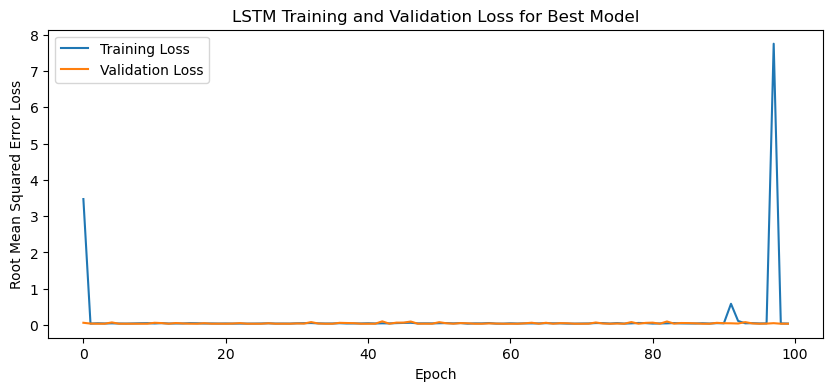

1/1 - 3s - loss: 0.0445 - 3s/epoch - 3s/step
Test Loss: 0.04446382448077202
1/1 [==============================] - 0s 68ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

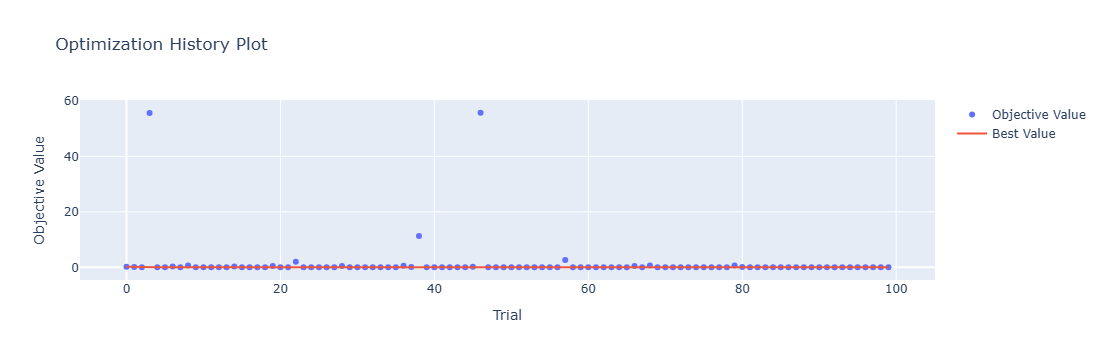

In [4]:
optuna.visualization.plot_optimization_history(study)

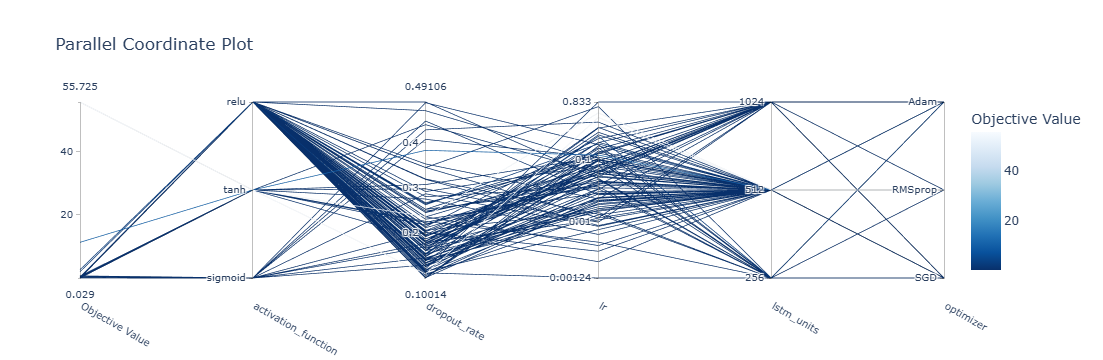

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

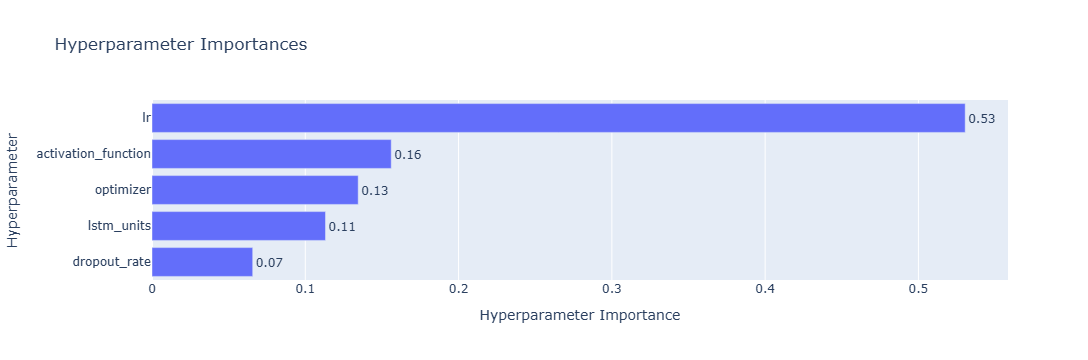

In [6]:
optuna.visualization.plot_param_importances(study)

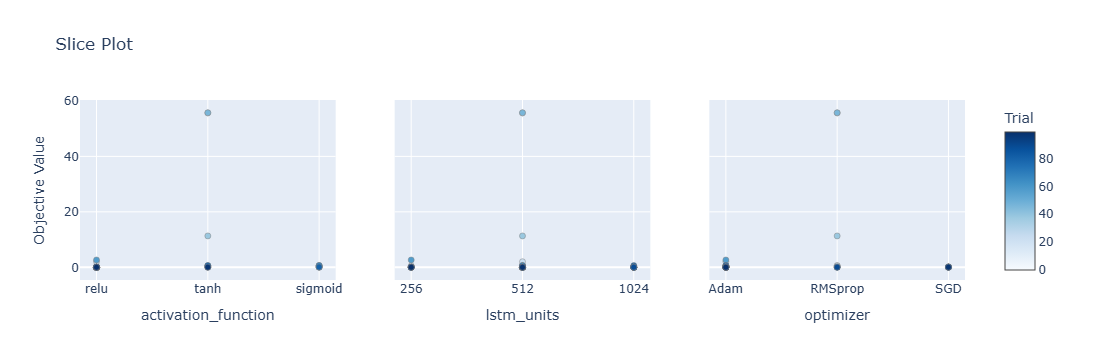

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

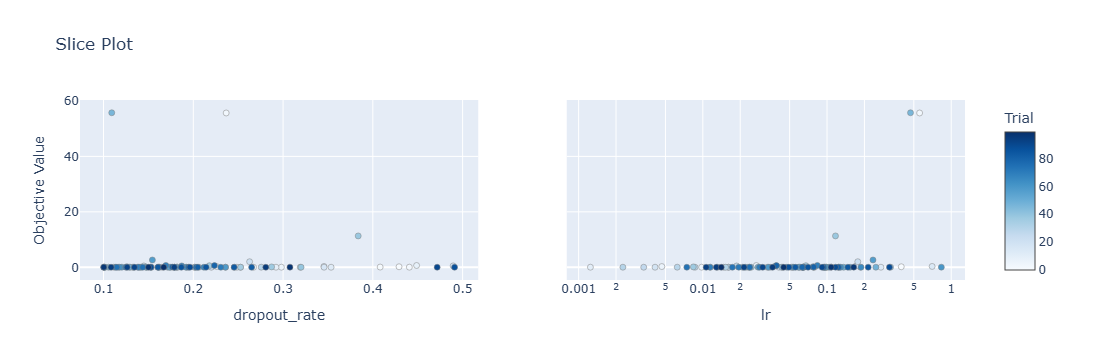

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 41s 208ms/step - loss: 5.4828 - accuracy: 0.0000e+00 - mae: 5.4828 - rmse: 5.4828 - mape: 1178.9814 - pearson: nan - val_loss: 0.0360 - val_accuracy: 0.0000e+00 - val_mae: 0.0360 - val_rmse: 0.0360 - val_mape: 8.1707 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 11s 125ms/step - loss: 0.1839 - accuracy: 0.0000e+00 - mae: 0.1839 - rmse: 0.1839 - mape: 39.3039 - pearson: nan - val_loss: 0.0691 - val_accuracy: 0.0000e+00 - val_mae: 0.0691 - val_rmse: 0.0691 - val_mape: 14.4773 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 9s 108ms/step - loss: 0.1081 - accuracy: 0.0000e+00 - mae: 0.1081 - rmse: 0.1081 - mape: 23.6524 - pearson: nan - val_loss: 0.1209 - val_accuracy: 0.0000e+00 - val_mae: 0.1209 - val_rmse: 0.1209 - val_mape: 27.1410 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 8s 97ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - mae: 0.0522 - rmse: 0.0522 - m

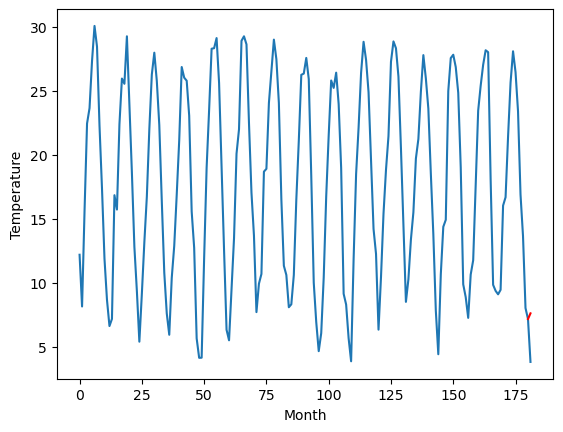

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		6.65		-1.88
[180, 181]
[13.23, 6.653749580383301]


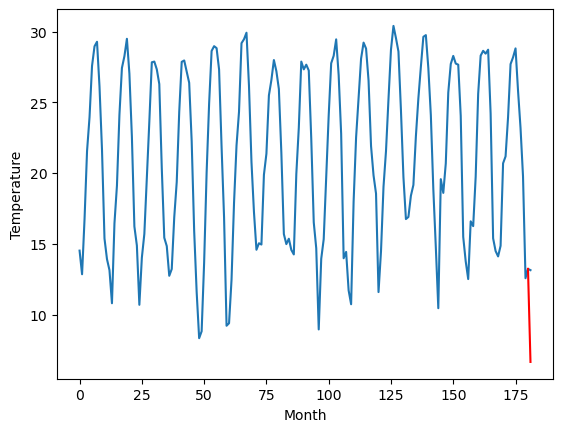

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.31		5.27		-2.04
[180, 181]
[7.18, 5.273749580383301]


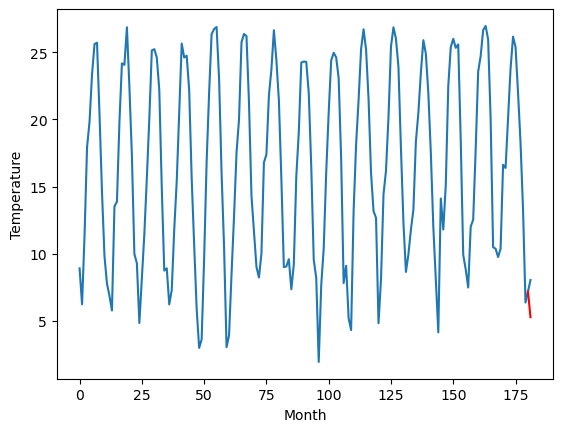

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.38		4.07		-1.31
[180, 181]
[11.46, 4.073749580383301]


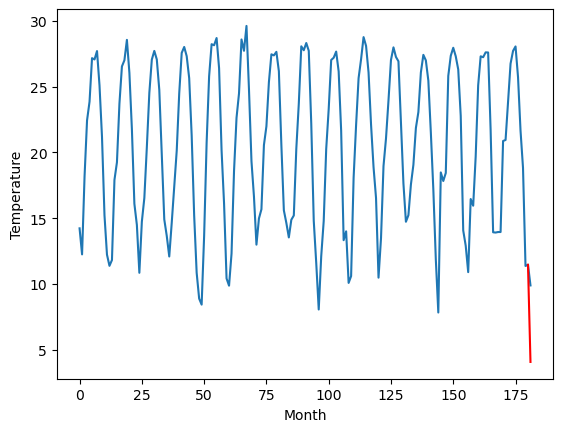

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.33		10.99		-0.34
[180, 181]
[9.27, 10.993749580383302]


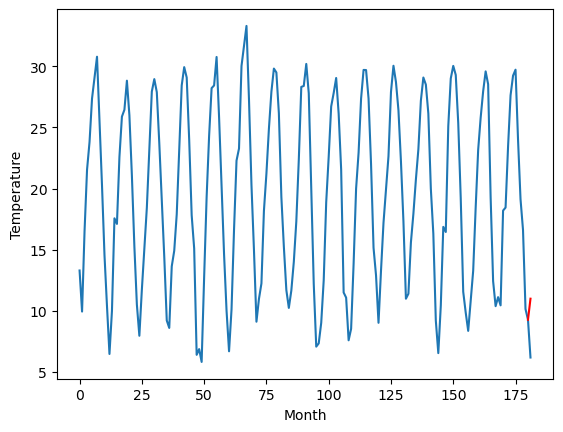

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.74		13.30		0.56
[180, 181]
[7.77, 13.3037495803833]


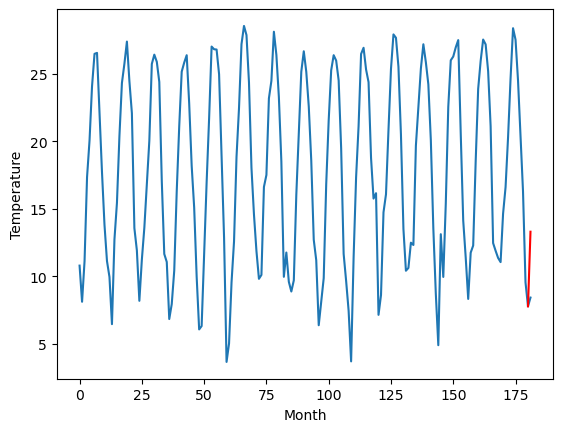

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.33		7.69		-0.64
[180, 181]
[6.59, 7.693749580383301]


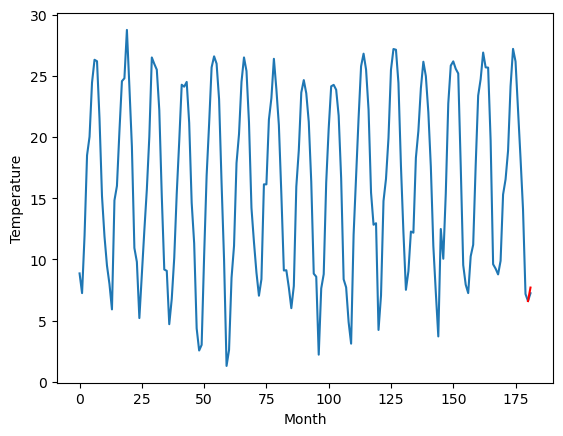

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.29		13.01		-0.28
[180, 181]
[5.3, 13.013749580383301]


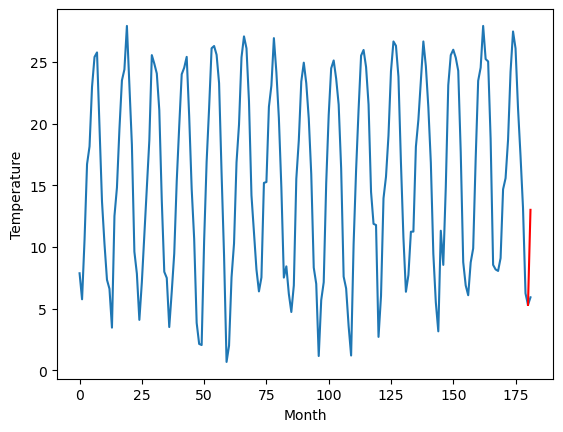

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.51		12.08		-0.43
[180, 181]
[3.1, 12.083749580383301]


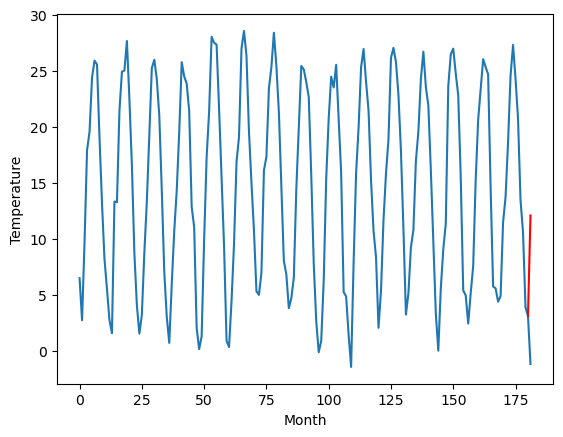

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.20		9.57		0.37
[180, 181]
[0.6, 9.5737495803833]


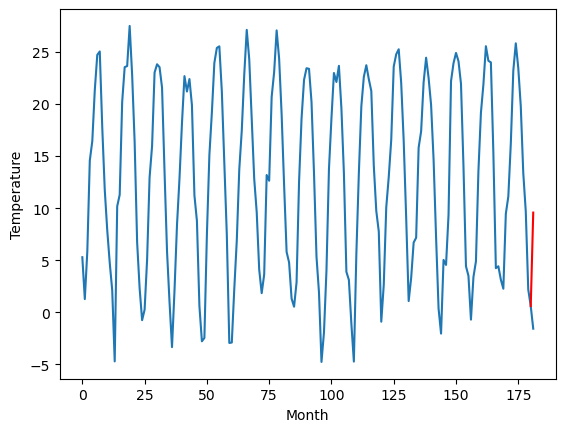

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.24		7.63		0.39
[180, 181]
[-0.75, 7.6337495803833]


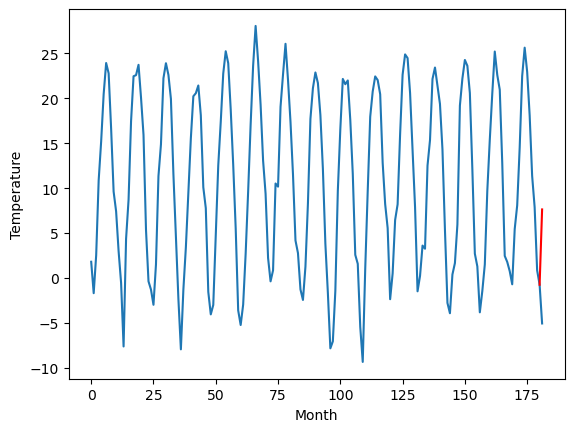

RangeIndex(start=1, stop=12, step=1)
[7.989999999999999, 8.53, 7.310000000000001, 5.3800000000000034, 11.33, 12.739999999999998, 8.33, 13.29, 12.51, 9.2, 7.24]
[7.6337495803833, 6.653749580383301, 5.273749580383301, 4.073749580383301, 10.993749580383302, 13.3037495803833, 7.693749580383301, 13.013749580383301, 12.083749580383301, 9.5737495803833, 7.6337495803833]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.99    7.63375
1                 1    8.53    6.65375
2                 2    7.31    5.27375
3                 3    5.38    4.07375
4                 4   11.33   10.99375
5                 5   12.74   13.30375
6                 6    8.33    7.69375
7                 7   13.29   13.01375
8                 8   12.51   12.08375
9                 9    9.20    9.57375
10               10    7.24    7.63375


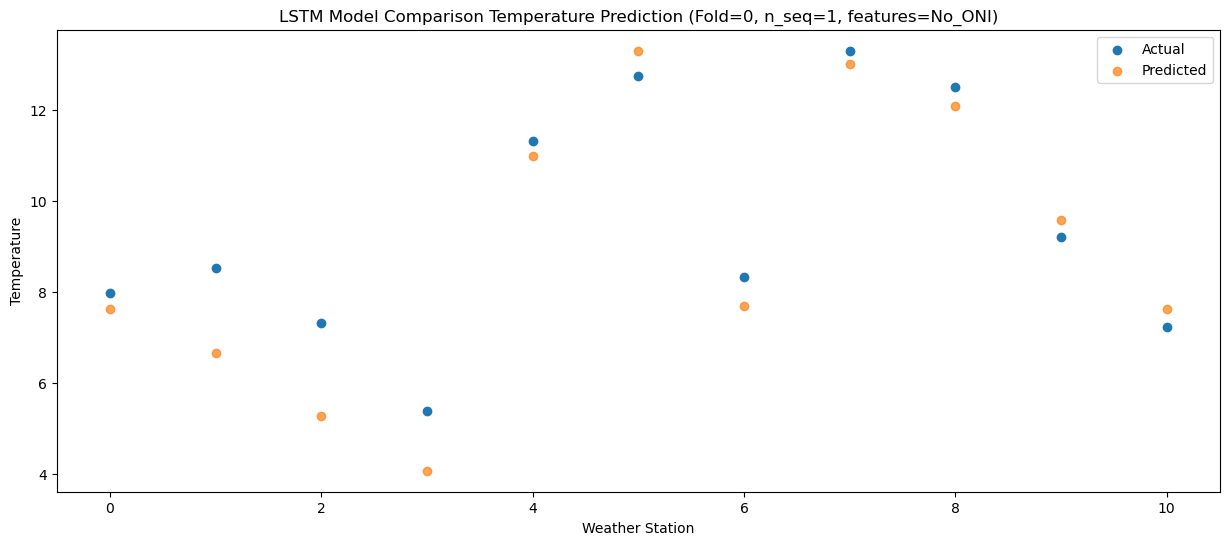

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_4 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_5 (LSTM)               (1, 512)                  2099200   
                                                                 
 dropout_5 (Dropout)         (1, 512)                  0         
                                                                 
 dense_6 (Dense)             (1, 256)                  131328    
                                                                 
 dense_7 (Dense)             (1, 128)                  32896     
                                                                 
 dense_8 (Dense)             (1, 1)                   

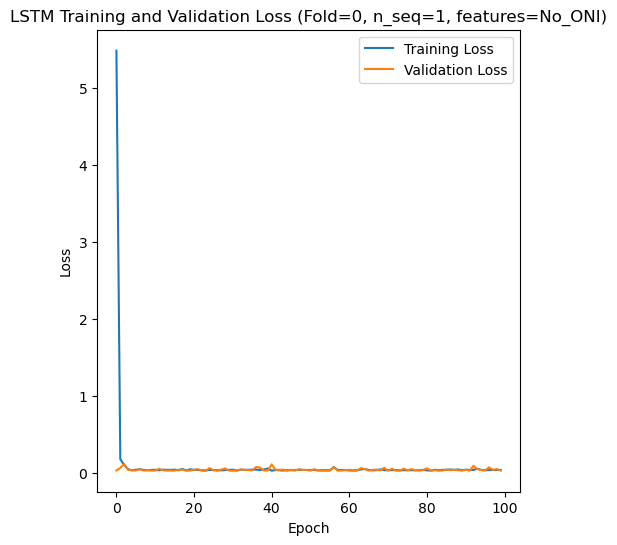

Epoch 1/100
84/84 [==============================] - 40s 197ms/step - loss: 5.6340 - accuracy: 0.0000e+00 - mae: 5.6340 - rmse: 5.6340 - mape: 1409.8834 - pearson: nan - val_loss: 0.0554 - val_accuracy: 0.0000e+00 - val_mae: 0.0554 - val_rmse: 0.0554 - val_mape: 12.1404 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 87ms/step - loss: 0.0481 - accuracy: 0.0000e+00 - mae: 0.0481 - rmse: 0.0481 - mape: 10.1981 - pearson: nan - val_loss: 0.0265 - val_accuracy: 0.0000e+00 - val_mae: 0.0265 - val_rmse: 0.0265 - val_mape: 5.4808 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 86ms/step - loss: 0.0462 - accuracy: 0.0000e+00 - mae: 0.0462 - rmse: 0.0462 - mape: 9.7925 - pearson: nan - val_loss: 0.0346 - val_accuracy: 0.0000e+00 - val_mae: 0.0346 - val_rmse: 0.0346 - val_mape: 7.7158 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 89ms/step - loss: 0.0429 - accuracy: 0.0000e+00 - mae: 0.0429 - rmse: 0.0429 - mape: 

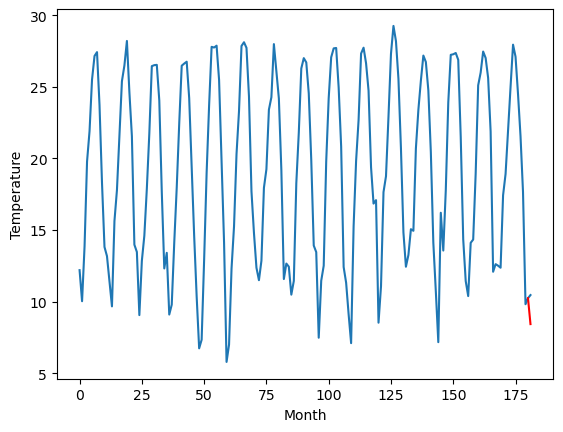

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.49		7.00		-0.49
[180, 181]
[6.41, 7.001962127685547]


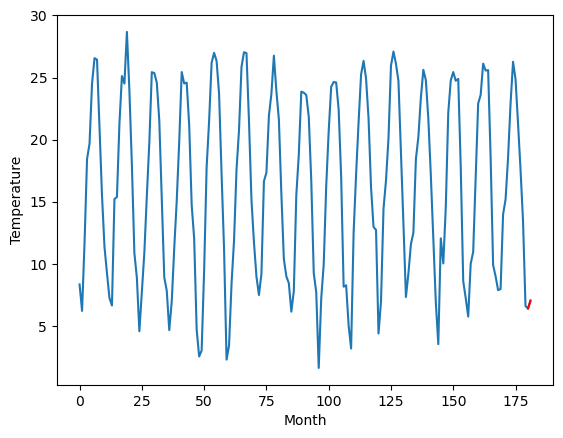

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.35		8.24		-1.11
[180, 181]
[7.6, 8.241962127685547]


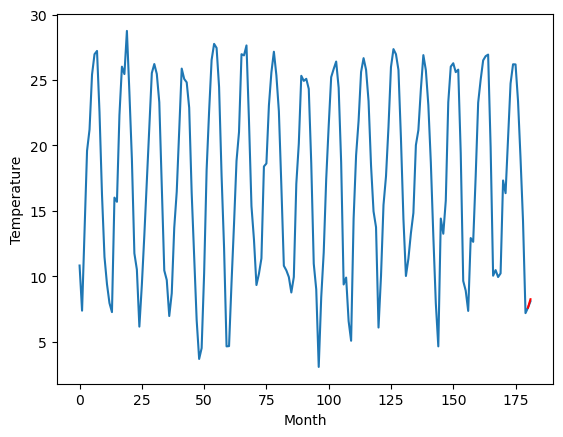

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.86		7.27		-0.59
[180, 181]
[11.89, 7.271962127685547]


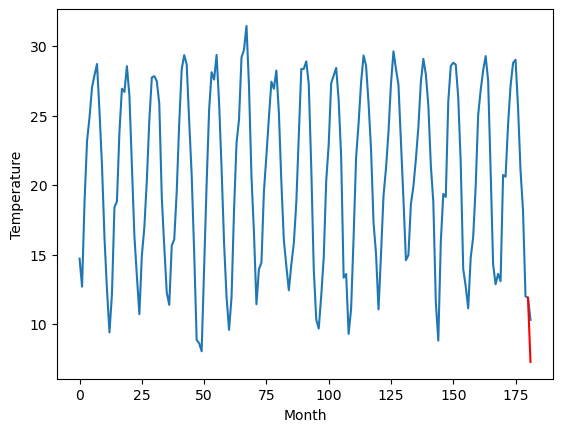

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.19		11.51		-0.68
[180, 181]
[10.96, 11.511962127685546]


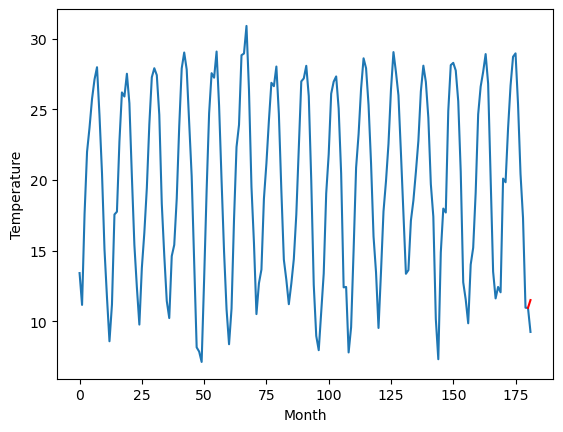

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.84		7.66		0.82
[180, 181]
[7.75, 7.6619621276855465]


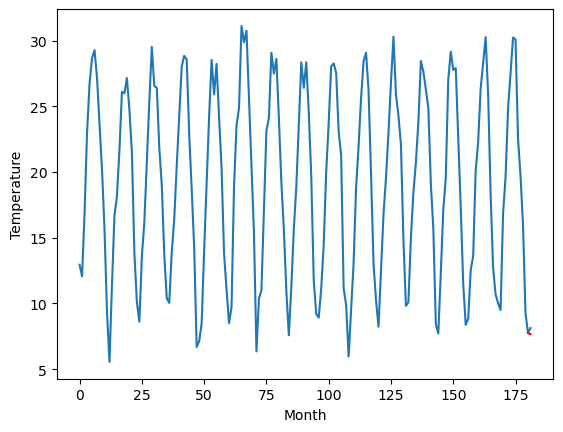

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.62		10.13		-0.49
[180, 181]
[6.17, 10.131962127685547]


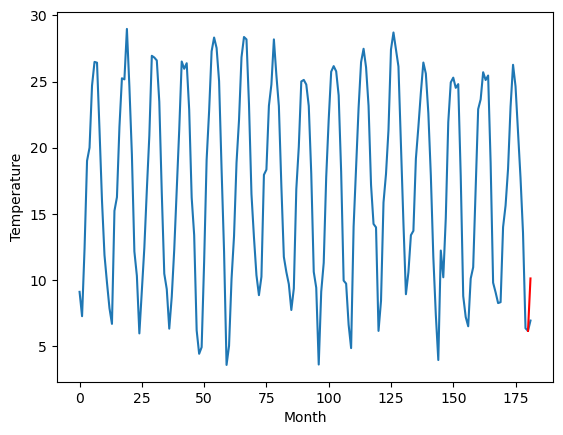

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.40		14.02		-0.38
[180, 181]
[4.57, 14.021962127685548]


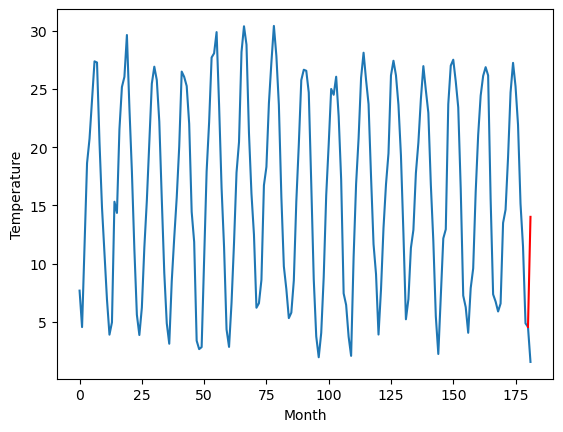

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.07		12.73		-0.34
[180, 181]
[5.46, 12.731962127685547]


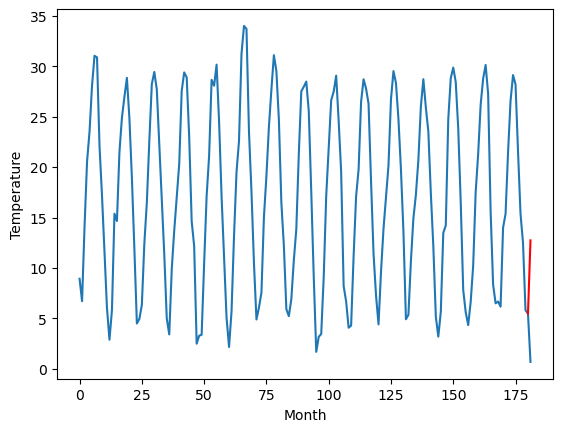

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.06		12.26		-0.80
[180, 181]
[5.42, 12.261962127685546]


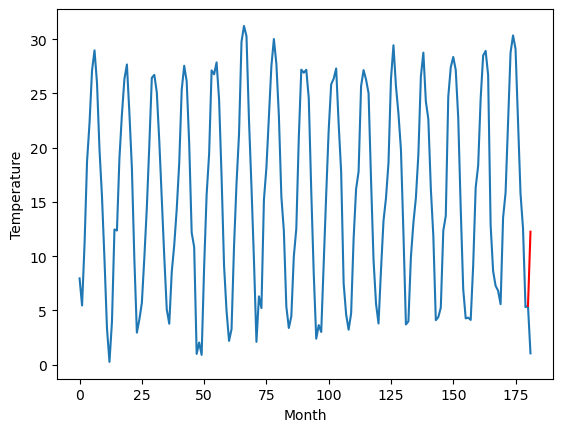

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.28		8.43		1.15
[180, 181]
[2.17, 8.431962127685546]


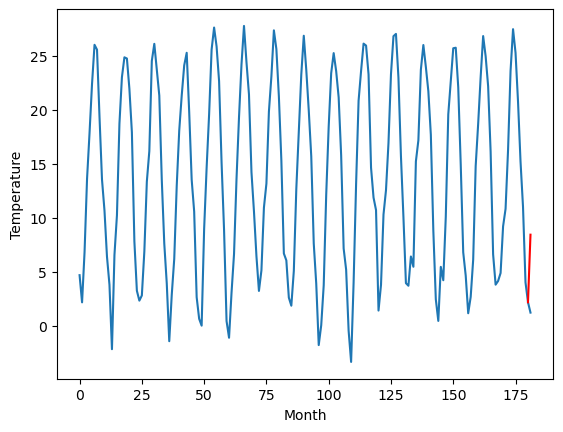

RangeIndex(start=1, stop=12, step=1)
[9.54, 7.489999999999999, 9.35, 7.859999999999999, 12.189999999999998, 6.84, 10.62, 14.4, 13.07, 13.06, 7.279999999999999]
[8.431962127685546, 7.001962127685547, 8.241962127685547, 7.271962127685547, 11.511962127685546, 7.6619621276855465, 10.131962127685547, 14.021962127685548, 12.731962127685547, 12.261962127685546, 8.431962127685546]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    9.54   8.431962
1                 1    7.49   7.001962
2                 2    9.35   8.241962
3                 3    7.86   7.271962
4                 4   12.19  11.511962
5                 5    6.84   7.661962
6                 6   10.62  10.131962
7                 7   14.40  14.021962
8                 8   13.07  12.731962
9                 9   13.06  12.261962
10               10    7.28   8.431962


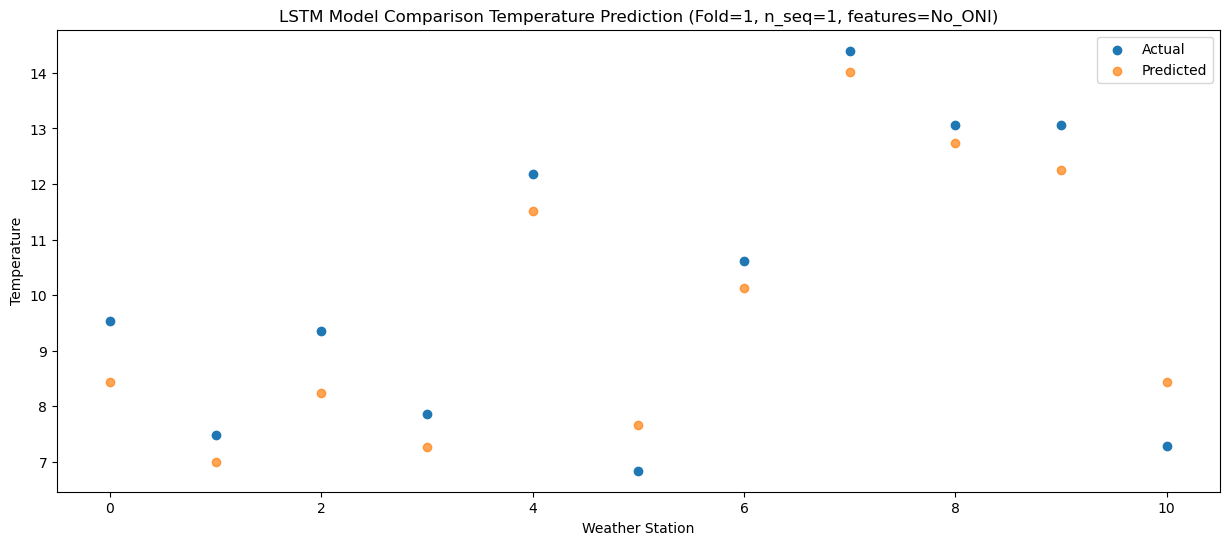

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_6 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_7 (LSTM)               (1, 512)                  2099200   
                                                                 
 dropout_7 (Dropout)         (1, 512)                  0         
                                                                 
 dense_9 (Dense)             (1, 256)                  131328    
                                                                 
 dense_10 (Dense)            (1, 128)                  32896     
                                                                 
 dense_11 (Dense)            (1, 1)                   

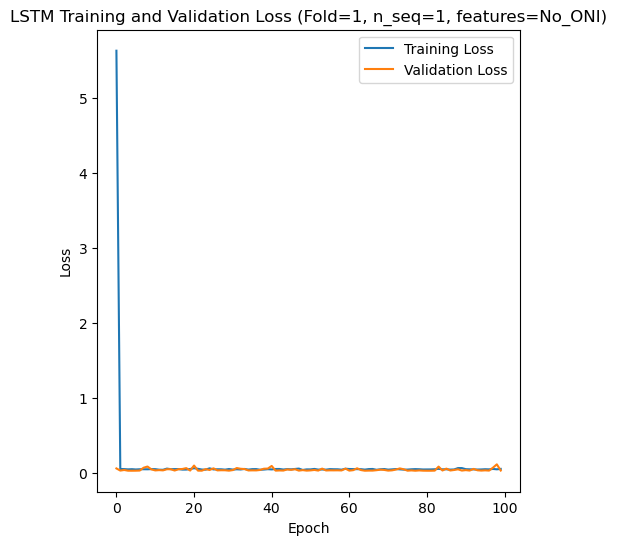

Epoch 1/100
84/84 [==============================] - 32s 209ms/step - loss: 5.4005 - accuracy: 0.0000e+00 - mae: 5.4005 - rmse: 5.4005 - mape: 1240.0840 - pearson: nan - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mae: 0.0209 - val_rmse: 0.0209 - val_mape: 4.5787 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 88ms/step - loss: 0.3176 - accuracy: 0.0000e+00 - mae: 0.3176 - rmse: 0.3176 - mape: 66.9023 - pearson: nan - val_loss: 0.1070 - val_accuracy: 0.0000e+00 - val_mae: 0.1070 - val_rmse: 0.1070 - val_mape: 24.1108 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 86ms/step - loss: 0.0567 - accuracy: 0.0000e+00 - mae: 0.0567 - rmse: 0.0567 - mape: 11.9907 - pearson: nan - val_loss: 0.0144 - val_accuracy: 0.0000e+00 - val_mae: 0.0144 - val_rmse: 0.0144 - val_mape: 3.2944 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 8s 95ms/step - loss: 0.1475 - accuracy: 0.0000e+00 - mae: 0.1475 - rmse: 0.1475 - mape:

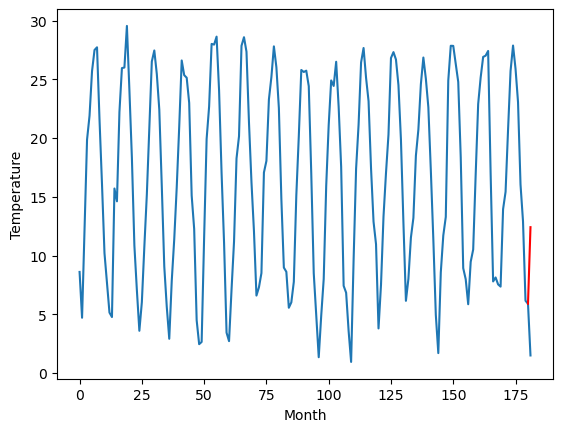

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.69		7.05		0.36
[180, 181]
[2.63, 7.049664427042007]


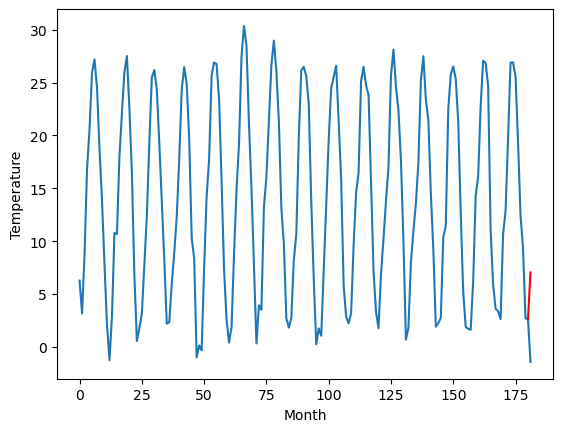

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.70		12.32		-0.38
[180, 181]
[16.55, 12.319664427042007]


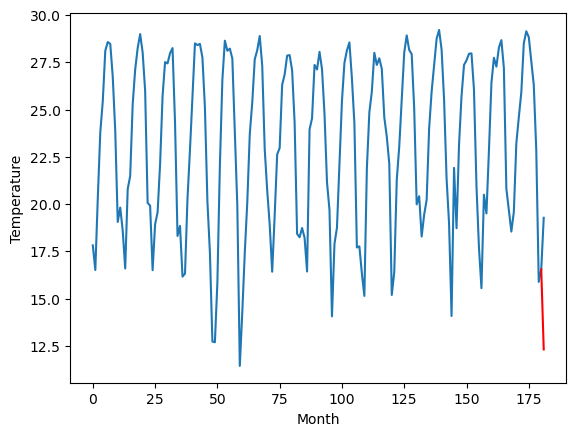

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.49		8.85		3.36
[180, 181]
[-0.83, 8.849664427042008]


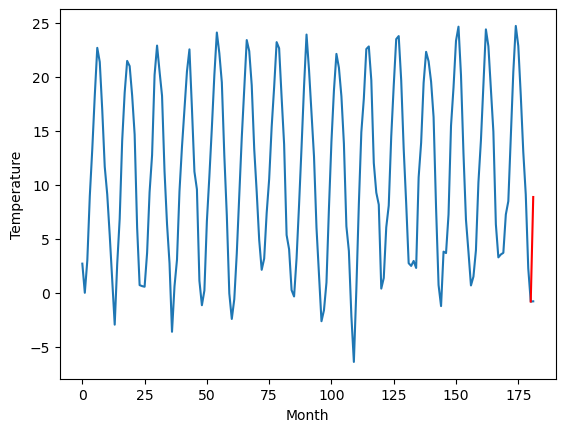

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.96		8.89		-0.07
[180, 181]
[11.52, 8.889664427042007]


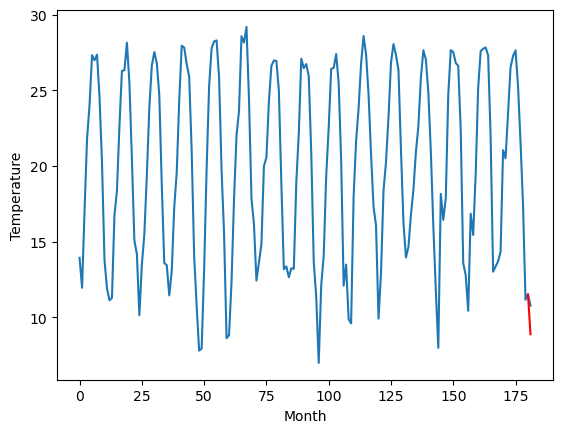

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.69		6.56		0.87
[180, 181]
[11.47, 6.559664427042008]


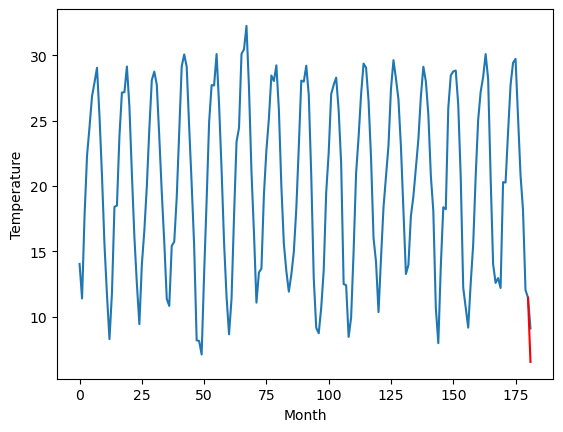

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.12		18.10		0.98
[180, 181]
[7.75, 18.099664427042008]


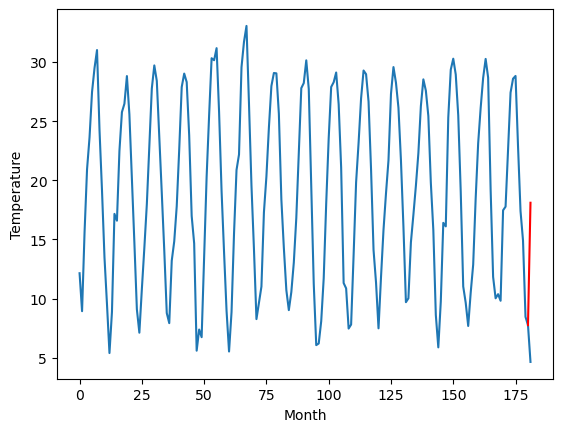

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.22		2.96		-0.26
[180, 181]
[4.9, 2.9596644270420076]


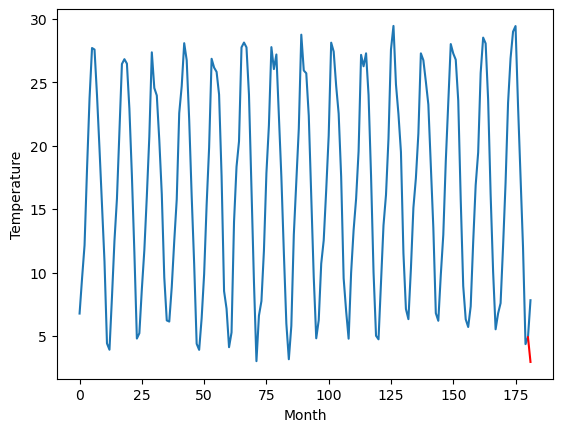

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.88		14.22		0.34
[180, 181]
[14.14, 14.219664427042007]


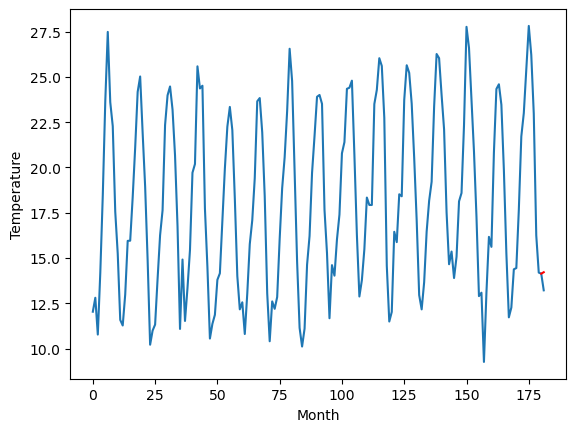

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.64		14.33		0.69
[180, 181]
[5.55, 14.329664427042008]


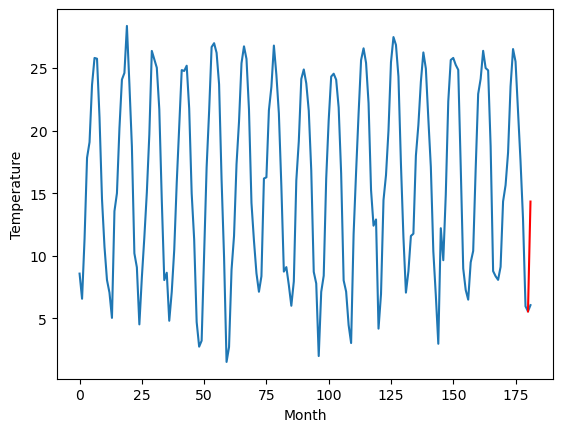

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.47		12.42		-0.05
[180, 181]
[3.19, 12.419664427042008]


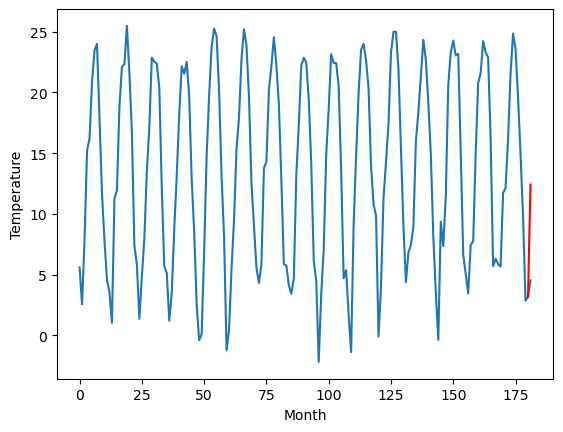

RangeIndex(start=1, stop=12, step=1)
[11.88, 6.69, 12.7, 5.490000000000001, 8.96, 5.69, 17.12, 3.2200000000000015, 13.880000000000003, 13.64, 12.47]
[12.419664427042008, 7.049664427042007, 12.319664427042007, 8.849664427042008, 8.889664427042007, 6.559664427042008, 18.099664427042008, 2.9596644270420076, 14.219664427042007, 14.329664427042008, 12.419664427042008]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   11.88  12.419664
1                 1    6.69   7.049664
2                 2   12.70  12.319664
3                 3    5.49   8.849664
4                 4    8.96   8.889664
5                 5    5.69   6.559664
6                 6   17.12  18.099664
7                 7    3.22   2.959664
8                 8   13.88  14.219664
9                 9   13.64  14.329664
10               10   12.47  12.419664


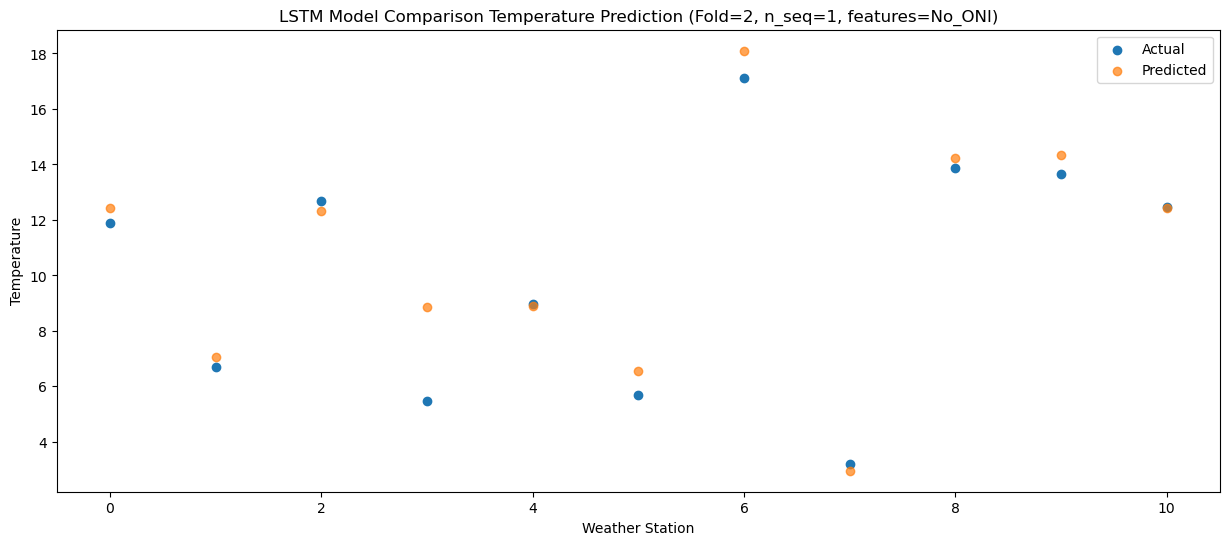

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_8 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_9 (LSTM)               (1, 512)                  2099200   
                                                                 
 dropout_9 (Dropout)         (1, 512)                  0         
                                                                 
 dense_12 (Dense)            (1, 256)                  131328    
                                                                 
 dense_13 (Dense)            (1, 128)                  32896     
                                                                 
 dense_14 (Dense)            (1, 1)                   

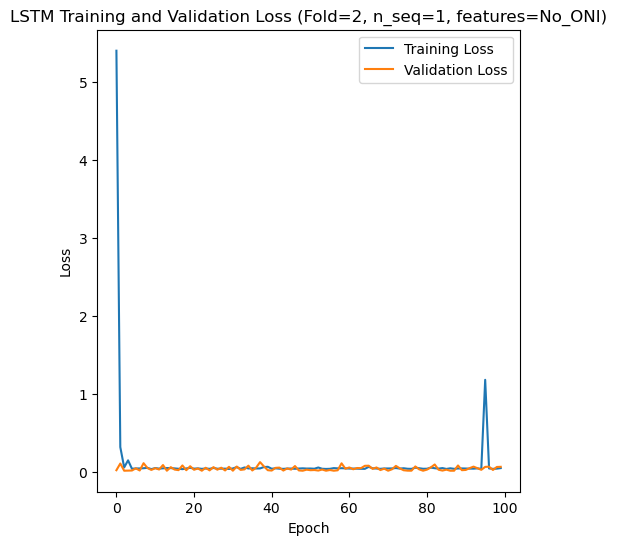

Epoch 1/100
84/84 [==============================] - 33s 145ms/step - loss: 5.0188 - accuracy: 0.0000e+00 - mae: 5.0188 - rmse: 5.0188 - mape: 1078.8752 - pearson: nan - val_loss: 0.0405 - val_accuracy: 0.0000e+00 - val_mae: 0.0405 - val_rmse: 0.0405 - val_mape: 8.5556 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 5s 61ms/step - loss: 0.1768 - accuracy: 0.0000e+00 - mae: 0.1768 - rmse: 0.1768 - mape: 39.8934 - pearson: nan - val_loss: 0.0453 - val_accuracy: 0.0000e+00 - val_mae: 0.0453 - val_rmse: 0.0453 - val_mape: 8.9890 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 5s 64ms/step - loss: 0.0699 - accuracy: 0.0000e+00 - mae: 0.0699 - rmse: 0.0699 - mape: 15.2183 - pearson: nan - val_loss: 0.0416 - val_accuracy: 0.0000e+00 - val_mae: 0.0416 - val_rmse: 0.0416 - val_mape: 8.8433 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 5s 62ms/step - loss: 0.0448 - accuracy: 0.0000e+00 - mae: 0.0448 - rmse: 0.0448 - mape: 

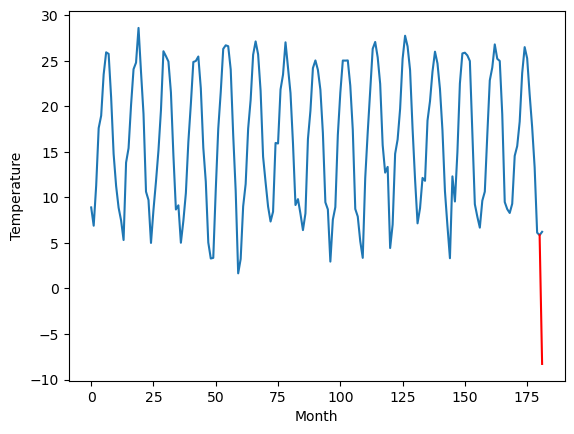

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.42		9.52		1.10
[180, 181]
[3.2, 9.523767519444228]


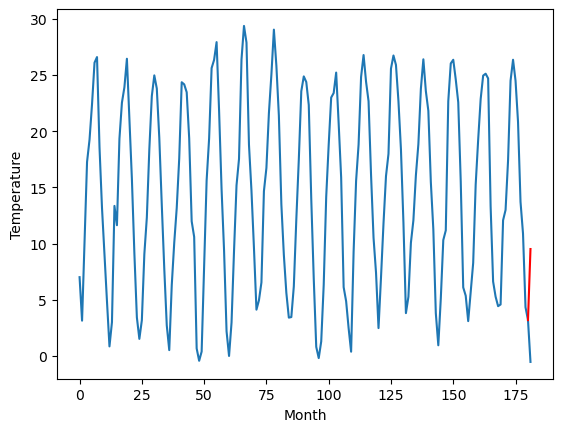

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.30		8.99		-1.31
[180, 181]
[8.48, 8.993767519444226]


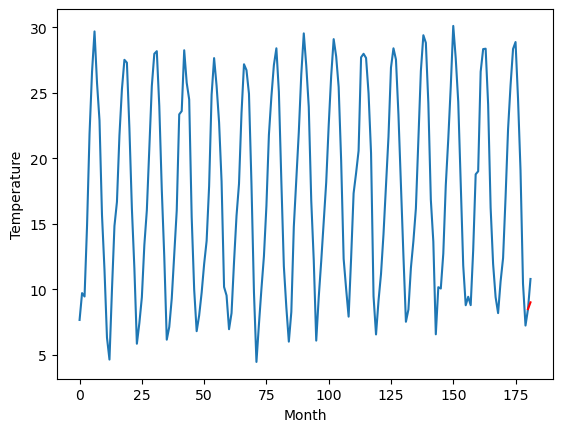

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.74		3.15		1.41
[180, 181]
[1.55, 3.1537675194442274]


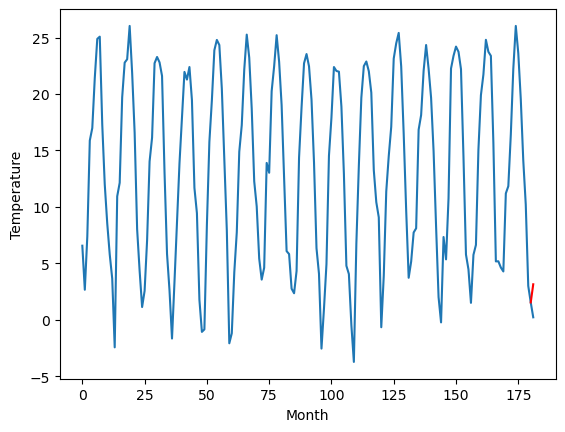

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.43		8.85		1.42
[180, 181]
[1.08, 8.853767519444228]


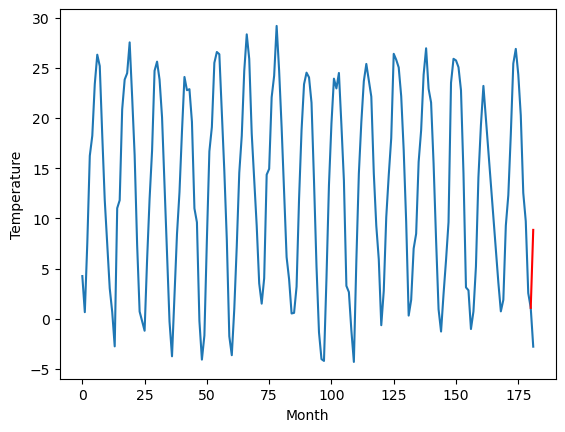

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.57		6.97		1.40
[180, 181]
[0.21, 6.973767519444227]


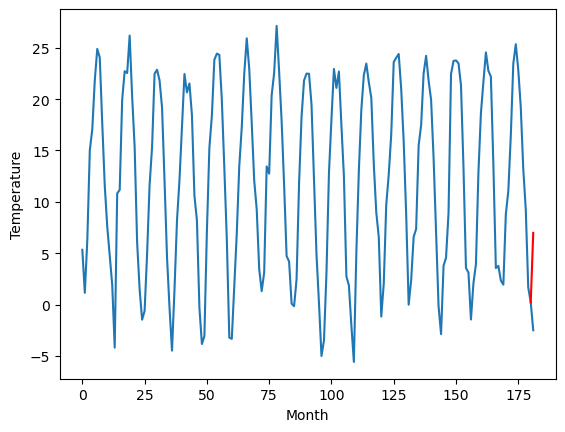

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.92		7.60		-0.32
[180, 181]
[-8.22, 7.603767519444228]


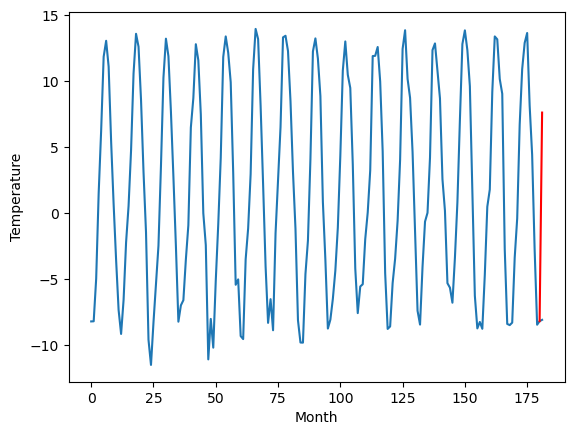

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.12		6.52		-0.60
[180, 181]
[10.04, 6.5237675194442275]


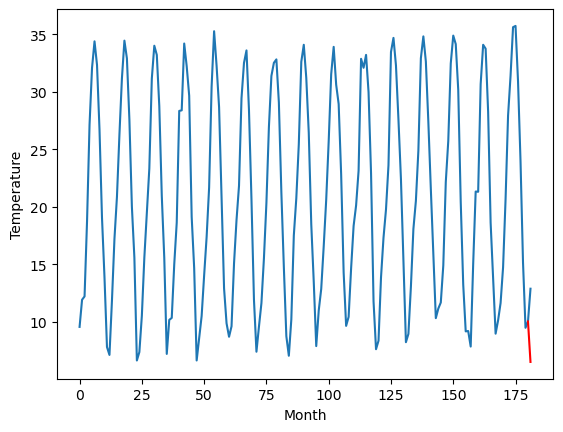

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.47		4.20		-1.27
[180, 181]
[9.17, 4.203767519444227]


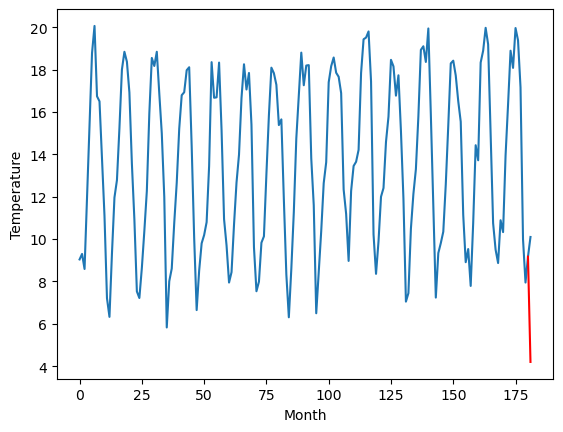

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.31		5.28		2.97
[180, 181]
[0.94, 5.283767519444227]


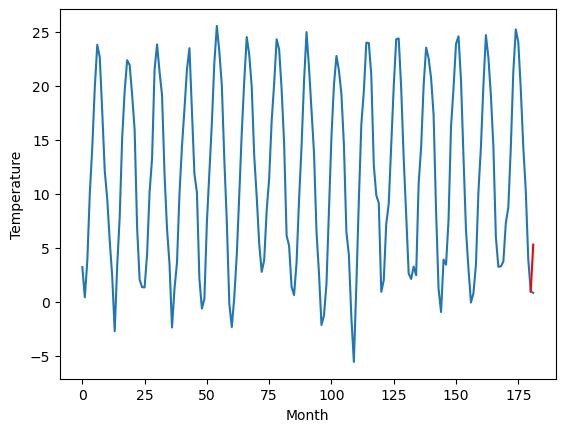

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-9.80		-8.29		1.51
[180, 181]
[-0.13, -8.286232480555773]


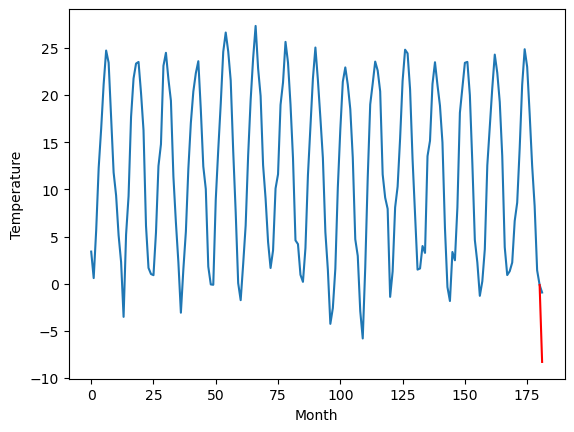

RangeIndex(start=1, stop=12, step=1)
[-8.520000000000001, 8.420000000000002, 10.299999999999999, 1.7399999999999998, 7.430000000000001, 5.5699999999999985, 7.92, 7.119999999999999, 5.4700000000000015, 2.3099999999999996, -9.8]
[-8.286232480555773, 9.523767519444228, 8.993767519444226, 3.1537675194442274, 8.853767519444228, 6.973767519444227, 7.603767519444228, 6.5237675194442275, 4.203767519444227, 5.283767519444227, -8.286232480555773]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   -8.52  -8.286232
1                 1    8.42   9.523768
2                 2   10.30   8.993768
3                 3    1.74   3.153768
4                 4    7.43   8.853768
5                 5    5.57   6.973768
6                 6    7.92   7.603768
7                 7    7.12   6.523768
8                 8    5.47   4.203768
9                 9    2.31   5.283768
10               10   -9.80  -8.286232


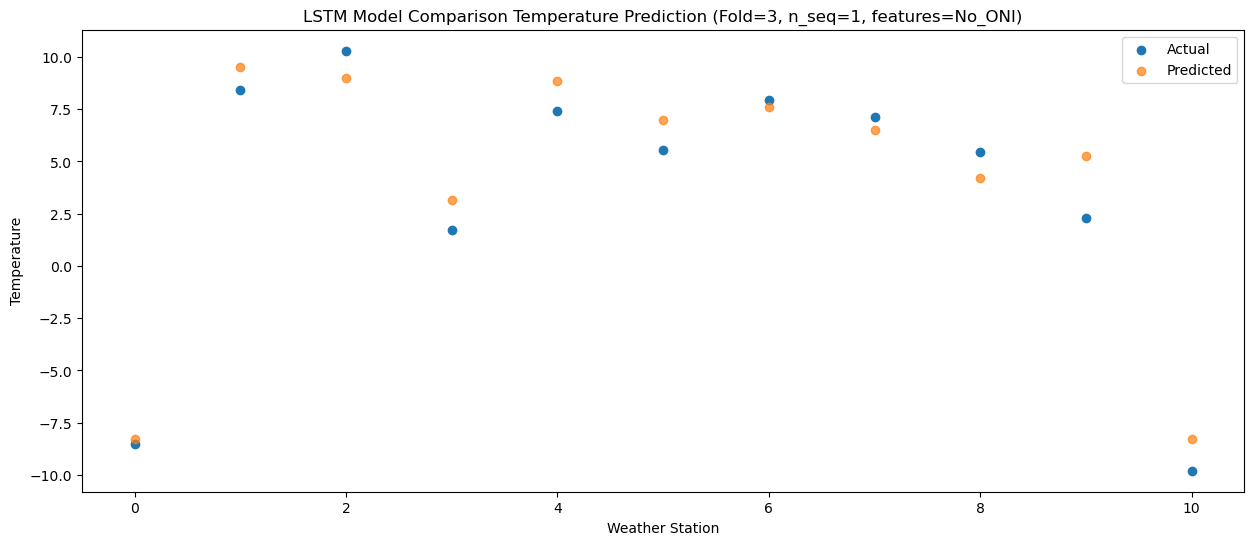

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1, 512)               5083136   
                                                                 
 dropout_10 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_11 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_11 (Dropout)        (1, 512)                  0         
                                                                 
 dense_15 (Dense)            (1, 256)                  131328    
                                                                 
 dense_16 (Dense)            (1, 128)                  32896     
                                                                 
 dense_17 (Dense)            (1, 1)                   

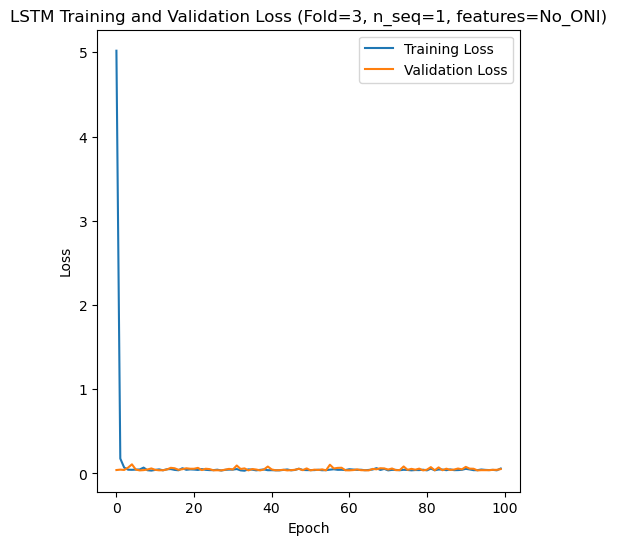

Epoch 1/100
84/84 [==============================] - 51s 196ms/step - loss: 4.1224 - accuracy: 0.0000e+00 - mae: 4.1224 - rmse: 4.1224 - mape: 896.5948 - pearson: nan - val_loss: 0.0690 - val_accuracy: 0.0000e+00 - val_mae: 0.0690 - val_rmse: 0.0690 - val_mape: 16.1976 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 8s 91ms/step - loss: 0.0405 - accuracy: 0.0000e+00 - mae: 0.0405 - rmse: 0.0405 - mape: 8.5804 - pearson: nan - val_loss: 0.0592 - val_accuracy: 0.0000e+00 - val_mae: 0.0592 - val_rmse: 0.0592 - val_mape: 13.5951 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 8s 100ms/step - loss: 0.0392 - accuracy: 0.0000e+00 - mae: 0.0392 - rmse: 0.0392 - mape: 8.1622 - pearson: nan - val_loss: 0.0480 - val_accuracy: 0.0000e+00 - val_mae: 0.0480 - val_rmse: 0.0480 - val_mape: 10.5226 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 8s 92ms/step - loss: 0.0414 - accuracy: 0.0000e+00 - mae: 0.0414 - rmse: 0.0414 - mape:

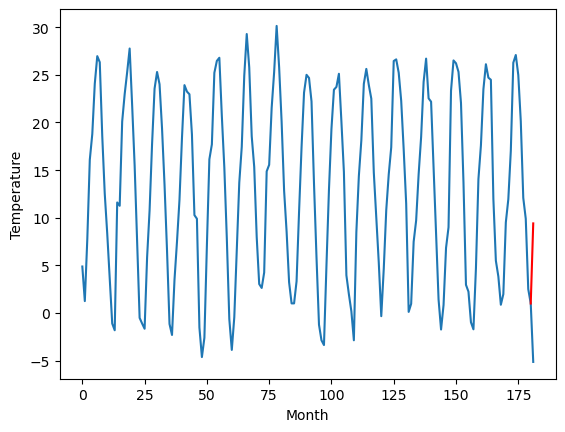

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		7.73		-0.61
[180, 181]
[14.25, 7.731959841549396]


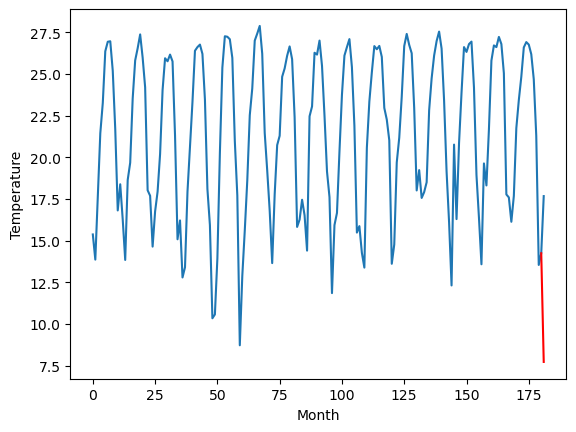

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		4.35		0.06
[180, 181]
[9.06, 4.351959841549396]


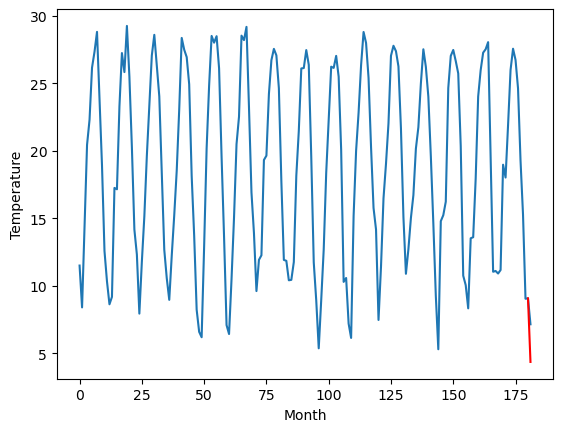

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		3.71		1.01
[180, 181]
[7.48, 3.7119598415493966]


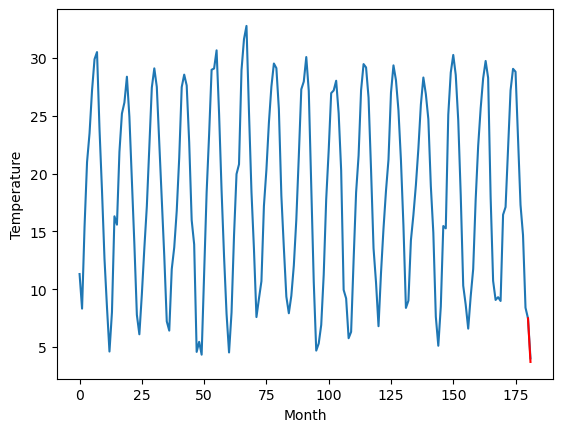

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		4.98		0.69
[180, 181]
[7.33, 4.981959841549396]


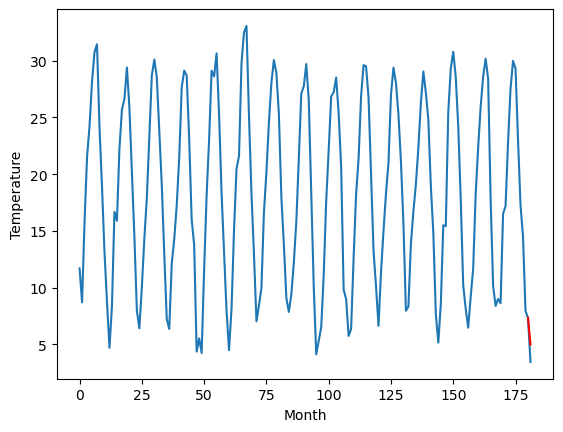

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		15.47		1.19
[180, 181]
[6.59, 15.471959841549397]


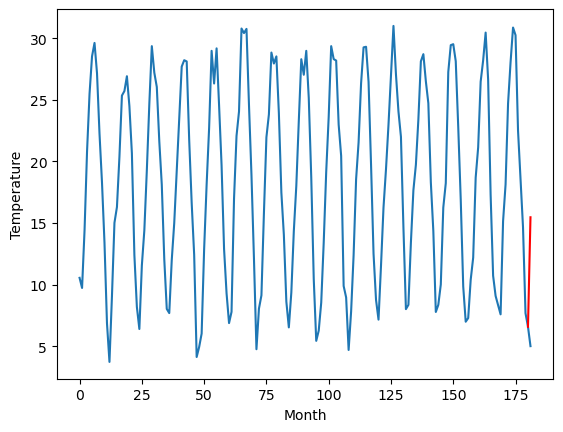

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		11.58		-0.14
[180, 181]
[6.04, 11.581959841549397]


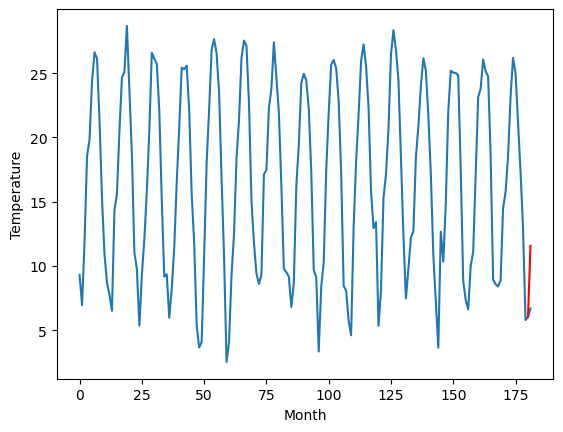

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		11.40		1.76
[180, 181]
[3.13, 11.401959841549397]


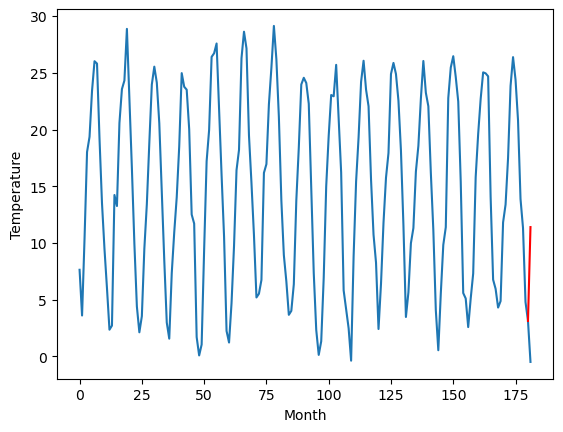

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		11.78		1.67
[180, 181]
[-0.29, 11.781959841549396]


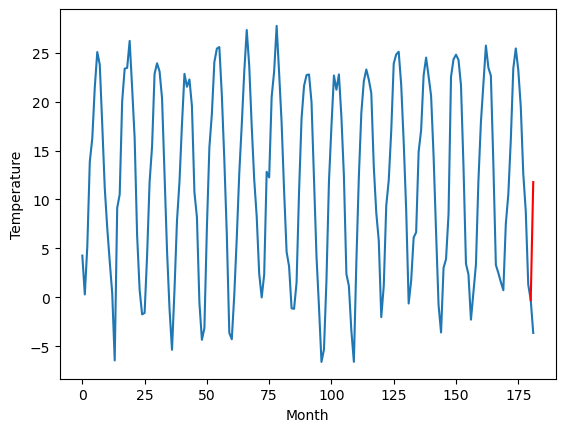

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		10.65		2.12
[180, 181]
[-1.03, 10.651959841549397]


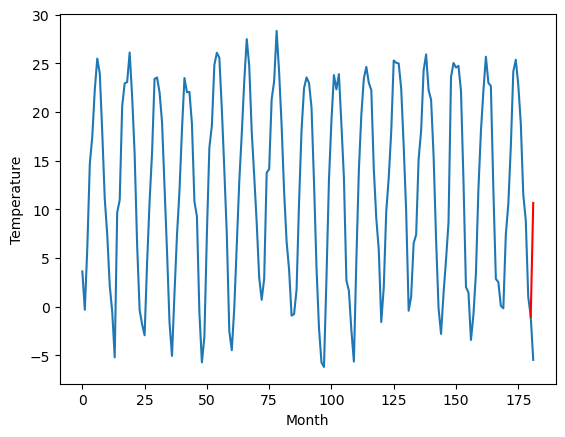

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		9.41		2.01
[180, 181]
[-2.29, 9.411959841549397]


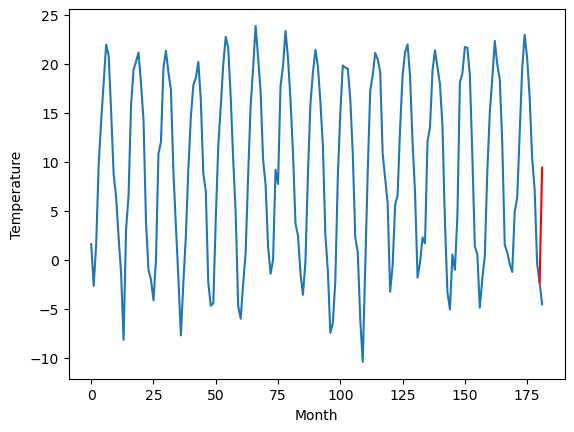

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[9.411959841549397, 7.731959841549396, 4.351959841549396, 3.7119598415493966, 4.981959841549396, 15.471959841549397, 11.581959841549397, 11.401959841549397, 11.781959841549396, 10.651959841549397, 9.411959841549397]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81    9.41196
1                 1    8.34    7.73196
2                 2    4.29    4.35196
3                 3    2.70    3.71196
4                 4    4.29    4.98196
5                 5   14.28   15.47196
6                 6   11.72   11.58196
7                 7    9.64   11.40196
8                 8   10.11   11.78196
9                 9    8.53   10.65196
10               10    7.40    9.41196


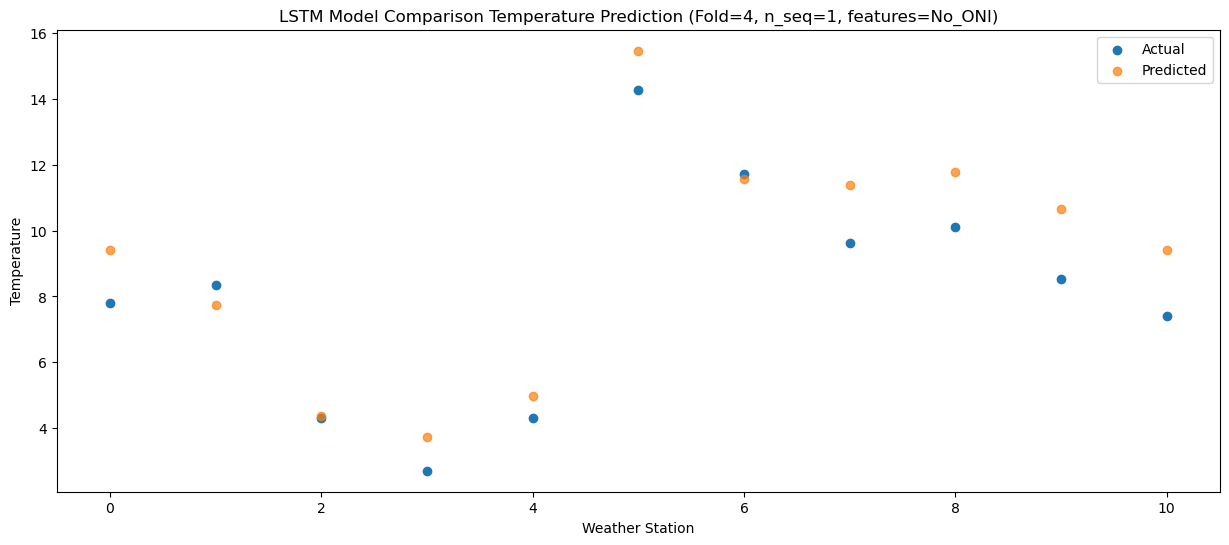

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (1, 1, 512)               5083136   
                                                                 
 dropout_12 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_13 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_13 (Dropout)        (1, 512)                  0         
                                                                 
 dense_18 (Dense)            (1, 256)                  131328    
                                                                 
 dense_19 (Dense)            (1, 128)                  32896     
                                                                 
 dense_20 (Dense)            (1, 1)                   

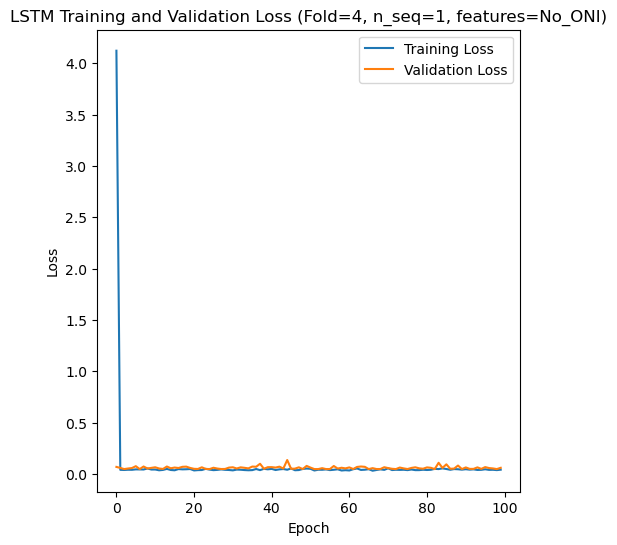

[[0.9949079288015744], [0.7765931919025791], [1.1375779424947836], [1.419642569950136], [1.3595844903622767]]
[[0.7801138270984996], [0.7223877369273789], [0.7180902982841836], [1.2319365962120623], [1.1703380809859791]]
[[0.09873441564080383], [0.07889373929265095], [0.1017209002643364], [0.3034971832267534], [0.16296491793934098]]
[[0.8417180751698826], [0.9078141829472968], [0.9260795405337984], [0.9510132221663525], [0.8257912800031717]]
[[[7.6337495803833], [6.653749580383301], [5.273749580383301], [4.073749580383301], [10.993749580383302], [13.3037495803833], [7.693749580383301], [13.013749580383301], [12.083749580383301], [9.5737495803833], [7.6337495803833]], [[8.431962127685546], [7.001962127685547], [8.241962127685547], [7.271962127685547], [11.511962127685546], [7.6619621276855465], [10.131962127685547], [14.021962127685548], [12.731962127685547], [12.261962127685546], [8.431962127685546]], [[12.419664427042008], [7.049664427042007], [12.319664427042007], [8.849664427042008]

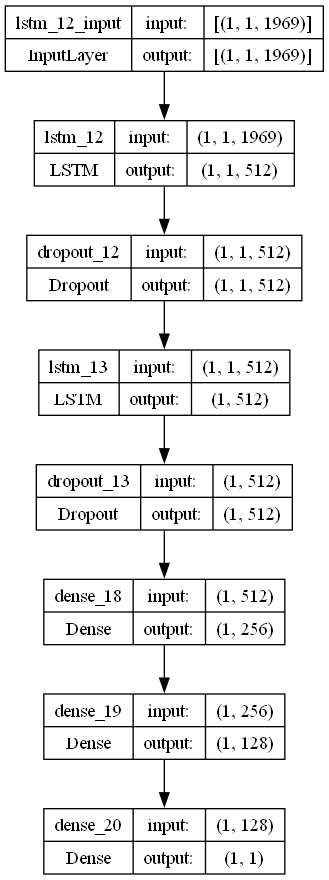

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.06423270616752934
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.17903509873660803

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)